# Stock Price Analysis and Comparison

Vincent Luong

Write brief introduction about time series analysis

In [1]:
import numpy as np
import pandas as pd

from datetime import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.tools as tls

from IPython.display import HTML

from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import  mean_squared_error

%matplotlib inline

## Importing Datasets and Summary Statistics

### Tesla

In [2]:
tesla_dat = pd.read_csv('data/tesla.csv')
tesla_dat.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
1,2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2,2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
3,2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
4,2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500


From the tesla dataset, we have 7 features (1 categorical and 6 numerical):

-`Date`: The date M/D/Y<br>
-`Open`: The opening price of stock (in USD) <br>
-`High`: The high price of that day (in USD) <br>
-`Low`: The low price of that day (in USD) <br> 
-`Close`: The closed price of that day (in USD) <br>
-`Volume`: The amount of stocks traded during that day <br>
-`Adj Close`: The stock's closing price that has been amended to include any distributions/coporate actions that occurs before next days open (in USD) <br>

In [3]:
tesla_dat.describe

<bound method NDFrame.describe of             Date         Open         High         Low        Close  \
0     2010-06-29     3.800000     5.000000    3.508000     4.778000   
1     2010-06-30     5.158000     6.084000    4.660000     4.766000   
2     2010-07-01     5.000000     5.184000    4.054000     4.392000   
3     2010-07-02     4.600000     4.620000    3.742000     3.840000   
4     2010-07-06     4.000000     4.000000    3.166000     3.222000   
...          ...          ...          ...         ...          ...   
2951  2022-03-18   874.489990   907.849976  867.390015   905.390015   
2952  2022-03-21   914.979980   942.849976  907.090027   921.159973   
2953  2022-03-22   930.000000   997.859985  921.750000   993.979980   
2954  2022-03-23   979.940002  1040.699951  976.400024   999.109985   
2955  2022-03-24  1009.729980  1024.489990  988.799988  1013.919983   

        Adj Close    Volume  
0        4.778000  93831500  
1        4.766000  85935500  
2        4.392000  4109

In [4]:
tesla_dat.shape

(2956, 7)

In [5]:
tesla_dat['Date'].min()

'2010-06-29'

In [6]:
tesla_dat['Date'].max()

'2022-03-24'

**Note**: Since the format is Y-M-D, it looks like the data ranges from the start of June 2010 to March 2022, for a total of 12 years.

### S&P 500 

In [7]:
s500_dat = pd.read_csv('data/s500.csv')
s500_dat.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


From the S&P 500 dataset, we also have 7 features.  With 5 numerical features and 2 categorical features we have the following:

-`date`: The date Y-M-D <br>
-`open`: Price of the stock at market open (in USD) <br>
-`high`: Highest price reached that day (in USD) <br>
-`low`: lowest price reached in the day (in USD) <br>
-`Volume`: Number of shares traded <br>
-`Name`: The stock's ticker name

In [8]:
s500_dat.describe

<bound method NDFrame.describe of               date   open   high    low  close    volume Name
0       2013-02-08  15.07  15.12  14.63  14.75   8407500  AAL
1       2013-02-11  14.89  15.01  14.26  14.46   8882000  AAL
2       2013-02-12  14.45  14.51  14.10  14.27   8126000  AAL
3       2013-02-13  14.30  14.94  14.25  14.66  10259500  AAL
4       2013-02-14  14.94  14.96  13.16  13.99  31879900  AAL
...            ...    ...    ...    ...    ...       ...  ...
619035  2018-02-01  76.84  78.27  76.69  77.82   2982259  ZTS
619036  2018-02-02  77.53  78.12  76.73  76.78   2595187  ZTS
619037  2018-02-05  76.64  76.92  73.18  73.83   2962031  ZTS
619038  2018-02-06  72.74  74.56  72.13  73.27   4924323  ZTS
619039  2018-02-07  72.70  75.00  72.69  73.86   4534912  ZTS

[619040 rows x 7 columns]>

In [9]:
#See if this dataset includes TSLA stocks

#unique_count = s500_dat['Name'].unique()
#for name in unique_count:
#    print(name)


#Code ran and it doesn't include Stocks from TSLA

In [10]:
s500_dat.shape

(619040, 7)

In [11]:
s500_dat['date'].min()

'2013-02-08'

In [12]:
s500_dat['date'].max()

'2018-02-07'

**Note**: Since the format is Y/M/D, the data ranges from the start of Feburary 2013 to Feburary 2018, for a total of 5 years.

## Discovering Seperate Measurements

Since the Tesla dataset doesn't include any non-date categorical variables, we can ignore that and perform EDA on the S&P 500 dataset.

In [13]:
s500_dat.sort_values(by="date").head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.1200,14.630,14.75,8407500,AAL
508224,2013-02-08,81.22,81.9300,80.940,81.89,296853,SLG
506965,2013-02-08,78.24,79.0700,78.125,79.07,4632684,SLB
85755,2013-02-08,236.64,238.6924,235.750,238.16,552207,BLK
505706,2013-02-08,89.04,89.4800,88.910,89.16,554948,SJM


From the above, we definitely see stock prices flucutating on the same date for different names, now lets group by names

In [14]:
s500_dat.sort_values(by=["Name", "date"]).head()

,date,open,high,low,close,volume,Name
71611,2013-02-08,45.07,45.35,45.00,45.08,1824755,A
71612,2013-02-11,45.17,45.18,44.45,44.60,2915405,A
71613,2013-02-12,44.81,44.95,44.50,44.62,2373731,A
71614,2013-02-13,44.81,45.24,44.68,44.75,2052338,A
71615,2013-02-14,44.72,44.78,44.36,44.58,3826245,A


Since we see that we have a sequence of dates with a single row per date, we can see that we have seperate timeseries for each combinations of `Name`.  This make sense as S&P 500 is an index fund composed of many stocks in the stock market.  To simplify the project, we will split the data to only analyze data that is from the **top 4 highest volumes** of trades.

## Finding the Markets with Highest Trade Volume

### Data Cleaning

In [15]:
#Convert to datetime
tesla_dat["Date"] = pd.to_datetime(tesla_dat["Date"])
s500_dat["date"] = pd.to_datetime(s500_dat["date"])

#make so tesla dataset uses 'date' instead of 'Date', and match the rest of the features in S&P 500
tesla_dat = tesla_dat.rename(columns={
    "Date": "date",
    "Open": "open",
    "High": "high",
    "Low": "low",
    "Close": "close",
    "Volume": "volume"
})

In [16]:
#Code taken from Kaggle Notebook https://www.kaggle.com/code/avikumart/timeseries-stock-price-analysis-forecasting

# rename Name to ticks
rdf = s500_dat.rename(columns={'Name':'ticks'})

# drop the null as they a few values and time-series won't be affected by such values
rdf.dropna(inplace=True)

# change the dtype of date column
new_df = rdf.copy()
new_df.loc[:, 'date'] = pd.to_datetime(rdf.loc[:, 'date'], format='%Y/%m/%d')

new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 619029 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    619029 non-null  datetime64[ns]
 1   open    619029 non-null  float64       
 2   high    619029 non-null  float64       
 3   low     619029 non-null  float64       
 4   close   619029 non-null  float64       
 5   volume  619029 non-null  int64         
 6   ticks   619029 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 37.8+ MB


C:\Users\vince\AppData\Local\Temp\ipykernel_14668\3230567191.py:11: DeprecationWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



### Finding Highest Mean Volume

In [17]:
# find the average volume of each stocks using function and sort top 4 most traded stocks for further analysis 
mean_dict = {}

# find average of volume traded over a period of time using for loops
for key in new_df['ticks'].unique():
    value = new_df[new_df['ticks'] == key ]['volume'].mean()
    mean_dict[key]= value

print("Length of the mean of ticks dictionary:", len(mean_dict))

# convert dict to pandas dataframe
avaerage_s = pd.Series(mean_dict).transpose()
top4_s = avaerage_s.sort_values(ascending=False)[:4]

print("Top 4 company tickers with highest average traded stock volume:\n", top4_s.index)

Length of the mean of ticks dictionary: 505
Top 4 company tickers with highest average traded stock volume:
 Index(['BAC', 'AAPL', 'GE', 'F'], dtype='object')


### Dividing the Dataframes

From the code above, we see that the markets with the highest volume are:
1. Bank of America
2. Apple
3. General Electric
4. Ford Motor Company

We will then divide the dataframes accordingly:

In [18]:
## Bank of America
bac_dat = s500_dat.loc[s500_dat['Name'] == 'BAC']
bac_dat.head()

,date,open,high,low,close,volume,Name
72870,2013-02-08,11.86,11.90,11.72,11.760,145217221,BAC
72871,2013-02-11,11.73,11.90,11.67,11.860,103499848,BAC
72872,2013-02-12,11.87,12.34,11.78,12.245,231771561,BAC
72873,2013-02-13,12.35,12.42,12.05,12.170,192478919,BAC
72874,2013-02-14,12.09,12.27,12.07,12.130,143901737,BAC


In [19]:
## Apple
apple_dat = s500_dat.loc[s500_dat['Name'] == 'AAPL']
apple_dat.head()

,date,open,high,low,close,volume,Name
1259,2013-02-08,67.7142,68.4014,66.8928,67.8542,158168416,AAPL
1260,2013-02-11,68.0714,69.2771,67.6071,68.5614,129029425,AAPL
1261,2013-02-12,68.5014,68.9114,66.8205,66.8428,151829363,AAPL
1262,2013-02-13,66.7442,67.6628,66.1742,66.7156,118721995,AAPL
1263,2013-02-14,66.3599,67.3771,66.2885,66.6556,88809154,AAPL


In [20]:
## General Electric
ge_dat = s500_dat.loc[s500_dat['Name'] == 'GE']
ge_dat.head()

,date,open,high,low,close,volume,Name
242754,2013-02-08,22.50,22.56,22.45,22.50,24424506,GE
242755,2013-02-11,22.49,22.51,22.35,22.45,19738628,GE
242756,2013-02-12,22.48,22.65,22.48,22.58,34139526,GE
242757,2013-02-13,23.11,23.48,23.04,23.39,84933955,GE
242758,2013-02-14,23.25,23.49,23.11,23.41,53990644,GE


In [21]:
## Facebook
fb_dat = s500_dat.loc[s500_dat['Name'] == 'F']
fb_dat.head()

,date,open,high,low,close,volume,Name
240236,2013-02-08,13.10,13.16,13.05,13.10,18596061,F
240237,2013-02-11,13.06,13.20,13.02,13.11,17685616,F
240238,2013-02-12,13.12,13.20,13.05,13.08,26231279,F
240239,2013-02-13,13.11,13.14,12.99,13.04,24501066,F
240240,2013-02-14,13.00,13.17,12.96,13.11,33487476,F


## Splitting the Data

Since there is mis-matching in the date ranges, we will focus on the dates the exists in both datasets to handle the differences in dates.

In [22]:
tesla_dat = tesla_dat[(tesla_dat['date'] >= '2013-02-08') & (tesla_dat['date'] <= '2018-02-07')]
print("Tesla Date Range:", tesla_dat["date"].min(), "to", tesla_dat["date"].max())
print("S&P 500 Date Range:", s500_dat["date"].min(), "to", s500_dat["date"].max())

Tesla Date Range: 2013-02-08 00:00:00 to 2018-02-07 00:00:00
S&P 500 Date Range: 2013-02-08 00:00:00 to 2018-02-07 00:00:00


Now that the dates are matched, we now have a total of 5 years of data from Feburary 2013 to Feburary 2018.  Lets split the data so we have **one year** of testing data for each dataframe.

In [23]:
#Creating Train/test split
split_date = pd.to_datetime('20170207', format='%Y%m%d')

tesla_train = tesla_dat[tesla_dat["date"] <= split_date]
tesla_test  = tesla_dat[tesla_dat["date"] >  split_date]

bac_train = bac_dat[bac_dat["date"] <= split_date]
bac_test = bac_dat[bac_dat["date"] > split_date]

apple_train = apple_dat[apple_dat["date"] <= split_date]
apple_test = apple_dat[apple_dat["date"] > split_date]

ge_train = ge_dat[ge_dat["date"] <= split_date]
ge_test = ge_dat[ge_dat["date"] > split_date]

fb_train = fb_dat[fb_dat["date"] <= split_date]
fb_test = fb_dat[fb_dat["date"] > split_date]

In [24]:
# Define a dictionary to hold the datasets
datasets = {
    "Tesla Train": tesla_train,
    "Tesla Test": tesla_test,
    "Bank of America Train": bac_train,
    "Bank of America Test": bac_test,
    "Apple Train": apple_train,
    "Apple Test": apple_test,
    "General Electric Train": ge_train,
    "General Electric Test": ge_test,
    "Facebook Train": fb_train,
    "Facebook Test": fb_test,
}

# Loop through the dictionary and print date ranges
for name, data in datasets.items():
    print(f"{name} Date Range: {data['date'].min()} to {data['date'].max()}")

Tesla Train Date Range: 2013-02-08 00:00:00 to 2017-02-07 00:00:00
Tesla Test Date Range: 2017-02-08 00:00:00 to 2018-02-07 00:00:00
Bank of America Train Date Range: 2013-02-08 00:00:00 to 2017-02-07 00:00:00
Bank of America Test Date Range: 2017-02-08 00:00:00 to 2018-02-07 00:00:00
Apple Train Date Range: 2013-02-08 00:00:00 to 2017-02-07 00:00:00
Apple Test Date Range: 2017-02-08 00:00:00 to 2018-02-07 00:00:00
General Electric Train Date Range: 2013-02-08 00:00:00 to 2017-02-07 00:00:00
General Electric Test Date Range: 2017-02-08 00:00:00 to 2018-02-07 00:00:00
Facebook Train Date Range: 2013-02-08 00:00:00 to 2017-02-07 00:00:00
Facebook Test Date Range: 2017-02-08 00:00:00 to 2018-02-07 00:00:00


## Explanatory Data Analysis

### Finding Missing Values 

We will first explore if there are any missing values, by using a dictionary and iterating through the datesets, we can explore the percentages of missing values for each respective dataset.  Ideally this should've been done before splitting because having missing values in our testing set could complicate our model and introduce bias.

In [25]:
# Define the datasets dictionary
datasets1 = {
    "Tesla": tesla_dat,
    "Bank of America": bac_dat,
    "Apple": apple_dat,
    "General Electric": ge_dat,
    "Facebook": fb_dat,
}

# Loop through the dictionary and calculate missing values
for name, df in datasets1.items():
    print(f"Missing Values in {name}:")
    missing_percentage = (df.isnull().sum() / len(df)) * 100  # Calculate percentage
    print(missing_percentage)  # Print percentage of missing values for each column
    print("-" * 50)  # Separator for readability

Missing Values in Tesla:
date         0.0
open         0.0
high         0.0
low          0.0
close        0.0
Adj Close    0.0
volume       0.0
dtype: float64
--------------------------------------------------
Missing Values in Bank of America:
date      0.0
open      0.0
high      0.0
low       0.0
close     0.0
volume    0.0
Name      0.0
dtype: float64
--------------------------------------------------
Missing Values in Apple:
date      0.0
open      0.0
high      0.0
low       0.0
close     0.0
volume    0.0
Name      0.0
dtype: float64
--------------------------------------------------
Missing Values in General Electric:
date      0.0
open      0.0
high      0.0
low       0.0
close     0.0
volume    0.0
Name      0.0
dtype: float64
--------------------------------------------------
Missing Values in Facebook:
date      0.0
open      0.0
high      0.0
low       0.0
close     0.0
volume    0.0
Name      0.0
dtype: float64
--------------------------------------------------


Luckily, there are no missing values in our main dataset, meaning, there are no missing values in our training/testing data splits.  This can mean we can move forward with our datasets.

### Adjusted Close Vs Close of Tesla Stocks

In the Telsa dataset, we have two different columns: `Close` and `Adj Close`.  In theory, it would be better to use the `Adj Close` column to find the adjusted closing price for the stock of tesla, however this might be seen as an advantage in comparison to the S&P 500 stocks, therefore we will first see if the 2 columns are the same first and move on from there.  

**Note** Ideally this should've been done before splitting the data

In [26]:
tesla_train.head()

,date,open,high,low,close,Adj Close,volume
658,2013-02-08,7.890,8.000,7.828,7.848,7.848,5699000
659,2013-02-11,7.596,7.830,7.500,7.684,7.684,16331500
660,2013-02-12,7.690,7.774,7.458,7.578,7.578,11306500
661,2013-02-13,7.660,7.800,7.610,7.690,7.690,4834000
662,2013-02-14,7.728,7.750,7.642,7.654,7.654,4953500


In [27]:
# Find rows where 'close' and 'adj_close' differ
differences = tesla_dat[tesla_dat["close"] != tesla_dat["Adj Close"]]

print(f"Number of rows with differences: {len(differences)}")
print(differences)

Number of rows with differences: 0
Empty DataFrame
Columns: [date, open, high, low, close, Adj Close, volume]
Index: []


In [28]:
# Check if 'close' and 'adj_close' columns are identical
are_equal = tesla_dat["close"].equals(tesla_dat["Adj Close"])

print("Are 'Close' and 'Adj Close' columns identical?", are_equal)

Are 'Close' and 'Adj Close' columns identical? True


Since these 2 columns are identical to one another and no advantage was given to `Adj Close` within this time frame, it can be reasonable to drop the `Adj Close` Column from the Tesla datasets.

In [29]:
#Drop columns
tesla_train = tesla_train.drop(columns=["Adj Close"])
tesla_test = tesla_test.drop(columns=["Adj Close"])

tesla_train.head()

,date,open,high,low,close,volume
658,2013-02-08,7.890,8.000,7.828,7.848,5699000
659,2013-02-11,7.596,7.830,7.500,7.684,16331500
660,2013-02-12,7.690,7.774,7.458,7.578,11306500
661,2013-02-13,7.660,7.800,7.610,7.690,4834000
662,2013-02-14,7.728,7.750,7.642,7.654,4953500


### Simple Plottings of Company Stock Prices and Volume of Trades

#### Tesla

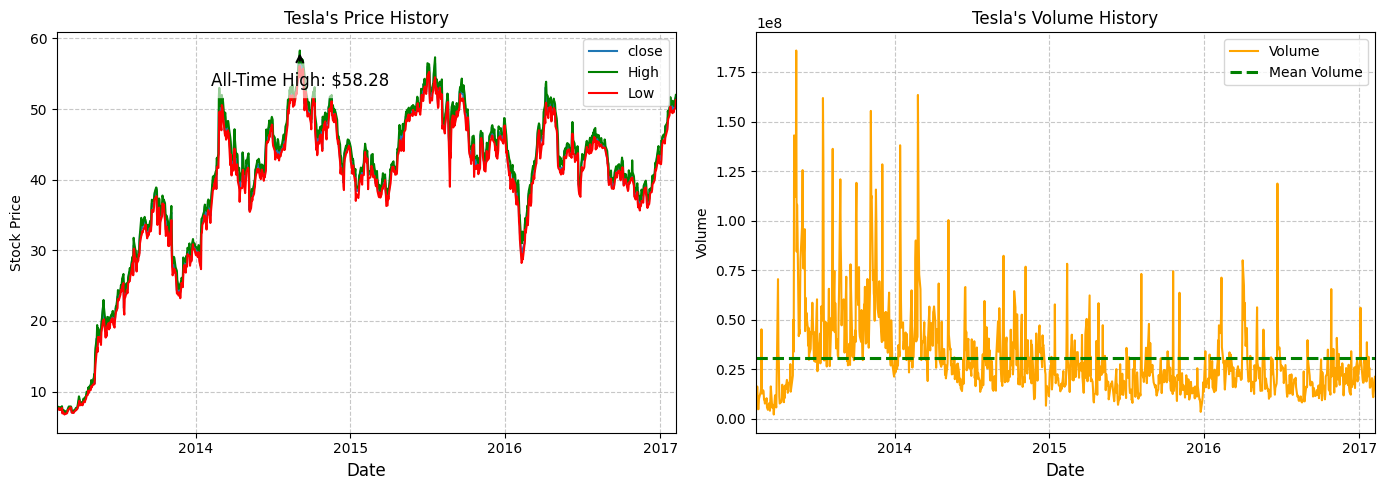

In [30]:
# First Subplot
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Close, High, and Low Prices on ax1
ax1.plot(tesla_train["date"], tesla_train["close"], label="close")
ax1.plot(tesla_train["date"], tesla_train["high"], color="green", label="High")
ax1.plot(tesla_train["date"], tesla_train["low"], color="red", label="Low")
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Stock Price")
ax1.set_title("Tesla's Price History")
ax1.legend()

# Find the all-time high
all_time_high = tesla_train["high"].max()
all_time_high_date = tesla_train[tesla_train["high"] == all_time_high]["date"].values[0]

# Annotate the all-time high (arrow pointing below)
ax1.annotate(
    f"All-Time High: ${all_time_high:.2f}",
    xy=(all_time_high_date, all_time_high),
    xytext=(all_time_high_date, all_time_high - 5),  # Place the text below
    arrowprops=dict(facecolor="black", arrowstyle="->", lw=1.5),
    fontsize=12,
    color="black",
    ha="center",
    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.5', alpha=0.6)  # Background for the text
)

# Volume on ax2
ax2.plot(tesla_train["date"], tesla_train["volume"], color="orange", label="Volume")
ax2.set_xlabel("Date", fontsize=12)
ax2.axhline(y=tesla_train['volume'].mean(), linestyle='--', lw=2.2, color='green', label="Mean Volume")
ax2.set_ylabel("Volume")
ax2.set_title("Tesla's Volume History")
ax2.legend()

for ax in [ax1, ax2]:
    ax.xaxis.set_major_locator(mdates.YearLocator())  # Major ticks every year
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))  # Format as 'YYYY'
    ax.set_xlim([tesla_train["date"].min(), tesla_train["date"].max()])  # Limit to data range
    ax.grid(True, linestyle="--", alpha=0.7)  # Optional grid for clarity

plt.tight_layout()
plt.show()

Producing the scatterplots for Stock Price and Dates we can see that Tesla had an upwards trend from 2013 to the middle of 2014, then it got relatively stable with most of its volume of trades happening around 2014.

#### Bank Of America

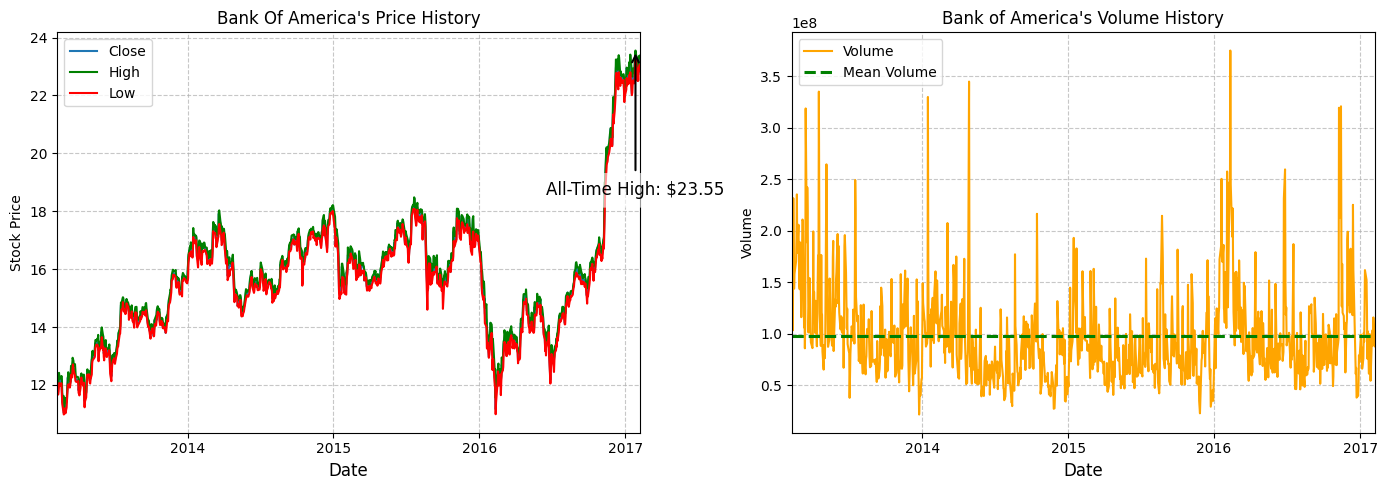

In [31]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Close, High, and Low Prices on ax1
ax1.plot(bac_train["date"], bac_train["close"], label="Close")
ax1.plot(bac_train["date"], bac_train["high"], color="green", label="High")
ax1.plot(bac_train["date"], bac_train["low"], color="red", label="Low")
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Stock Price")
ax1.set_title("Bank Of America's Price History")
ax1.legend()

# Find the all-time high
all_time_high = bac_train["high"].max()
all_time_high_date = bac_train[bac_train["high"] == all_time_high]["date"].values[0]

# Annotate the all-time high (arrow pointing below)
ax1.annotate(
    f"All-Time High: ${all_time_high:.2f}",
    xy=(all_time_high_date, all_time_high),
    xytext=(all_time_high_date, all_time_high - 5),  # Place the text below
    arrowprops=dict(facecolor="black", arrowstyle="->", lw=1.5),
    fontsize=12,
    color="black",
    ha="center",
    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.5', alpha=0.6)  # Background for the text
)

# Volume on ax2
ax2.plot(bac_train["date"], bac_train["volume"], color="orange", label="Volume")
ax2.set_xlabel("Date", fontsize=12)
ax2.axhline(y=bac_train['volume'].mean(), linestyle='--', lw=2.2, color='green', label="Mean Volume")
ax2.set_ylabel("Volume")
ax2.set_title("Bank of America's Volume History")
ax2.legend()

for ax in [ax1, ax2]:
    ax.xaxis.set_major_locator(mdates.YearLocator())  # Major ticks every year
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))  # Format as 'YYYY'
    ax.set_xlim([bac_train["date"].min(), bac_train["date"].max()])  # Limit to data range
    ax.grid(True, linestyle="--", alpha=0.7)  # Optional grid for clarity

plt.tight_layout()
plt.show()

Looking at the Bank of America charts, we can see that the stock price was increasing until 2014 and reamined relatively stable until 2016.  It is then met with a drop in stock price followed by a drastic increase in stock price.  Looking at the `volume` history, we can see that the trades for this stock market are relatively stable.

#### Apple

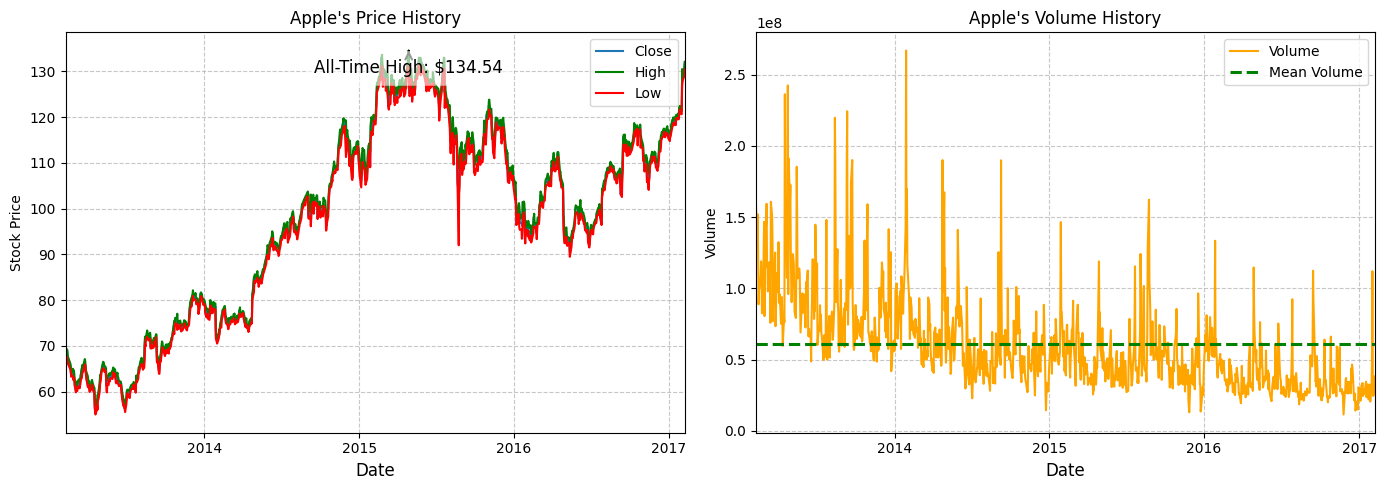

In [32]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Close, High, and Low Prices on ax1
ax1.plot(apple_train["date"], apple_train["close"], label="Close")
ax1.plot(apple_train["date"], apple_train["high"], color="green", label="High")
ax1.plot(apple_train["date"], apple_train["low"], color="red", label="Low")
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Stock Price")
ax1.set_title("Apple's Price History")
ax1.legend()

# Find the all-time high
all_time_high = apple_train["high"].max()
all_time_high_date = apple_train[apple_train["high"] == all_time_high]["date"].values[0]

# Annotate the all-time high (arrow pointing below)
ax1.annotate(
    f"All-Time High: ${all_time_high:.2f}",
    xy=(all_time_high_date, all_time_high),
    xytext=(all_time_high_date, all_time_high - 5),  # Place the text below
    arrowprops=dict(facecolor="black", arrowstyle="->", lw=1.5),
    fontsize=12,
    color="black",
    ha="center",
    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.5', alpha=0.6)  # Background for the text
)

# Volume on ax2
ax2.plot(apple_train["date"], apple_train["volume"], color="orange", label="Volume")
ax2.set_xlabel("Date", fontsize=12)
ax2.axhline(y=apple_train['volume'].mean(), linestyle='--', lw=2.2, color='green', label="Mean Volume")
ax2.set_ylabel("Volume")
ax2.set_title("Apple's Volume History")
ax2.legend()

for ax in [ax1, ax2]:
    ax.xaxis.set_major_locator(mdates.YearLocator())  # Major ticks every year
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))  # Format as 'YYYY'
    ax.set_xlim([apple_train["date"].min(), apple_train["date"].max()])  # Limit to data range
    ax.grid(True, linestyle="--", alpha=0.7)  # Optional grid for clarity

plt.tight_layout()
plt.show()

Viewing the scatterplots for Apple, we see that the stock price of apple has been increaseing from the start till around mid-2015.  Then it is met with a decrease until mid 2016.  Lastly the stock price has been increasing since.  Moving over to the `volume` history of Apple, we can see that the `volume` of trades happening at apple has a decreasing trend over time, but still remained relatively stable.

#### General Electric

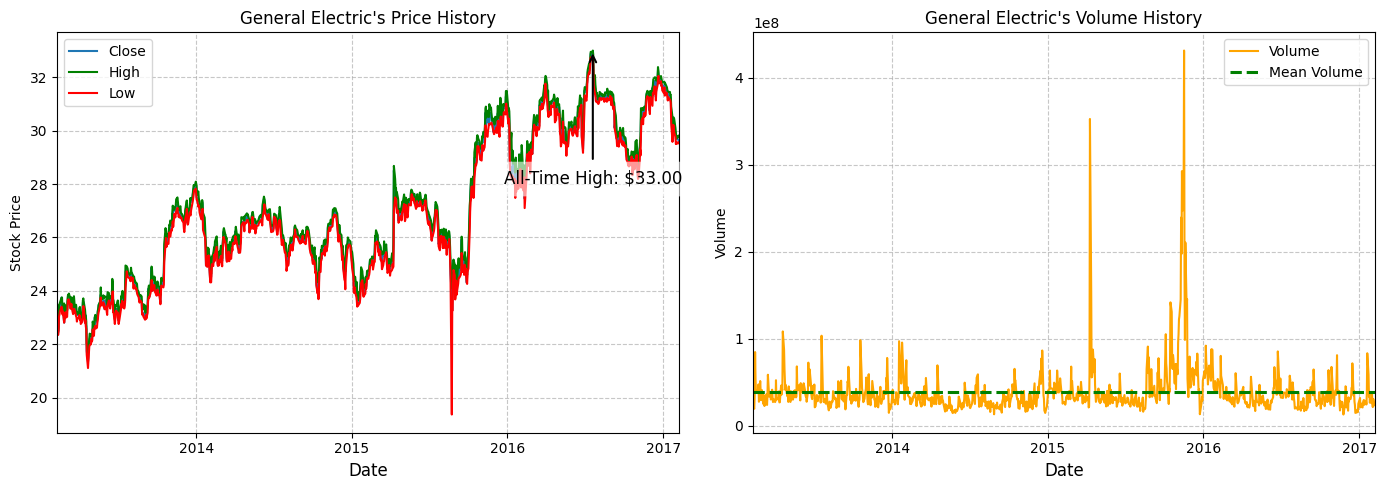

In [33]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Close, High, and Low Prices on ax1
ax1.plot(ge_train["date"], ge_train["close"], label="Close")
ax1.plot(ge_train["date"], ge_train["high"], color="green", label="High")
ax1.plot(ge_train["date"], ge_train["low"], color="red", label="Low")
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Stock Price")
ax1.set_title("General Electric's Price History")
ax1.legend()

# Find the all-time high
all_time_high = ge_train["high"].max()
all_time_high_date = ge_train[ge_train["high"] == all_time_high]["date"].values[0]

# Annotate the all-time high (arrow pointing below)
ax1.annotate(
    f"All-Time High: ${all_time_high:.2f}",
    xy=(all_time_high_date, all_time_high),
    xytext=(all_time_high_date, all_time_high - 5),  # Place the text below
    arrowprops=dict(facecolor="black", arrowstyle="->", lw=1.5),
    fontsize=12,
    color="black",
    ha="center",
    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.5', alpha=0.6)  # Background for the text
)

# Volume on ax2
ax2.plot(ge_train["date"], ge_train["volume"], color="orange", label="Volume")
ax2.set_xlabel("Date", fontsize=12)
ax2.axhline(y=ge_train['volume'].mean(), linestyle='--', lw=2.2, color='green', label="Mean Volume")
ax2.set_ylabel("Volume")
ax2.set_title("General Electric's Volume History")
ax2.legend()

for ax in [ax1, ax2]:
    ax.xaxis.set_major_locator(mdates.YearLocator())  # Major ticks every year
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))  # Format as 'YYYY'
    ax.set_xlim([ge_train["date"].min(), ge_train["date"].max()])  # Limit to data range
    ax.grid(True, linestyle="--", alpha=0.7)  # Optional grid for clarity

plt.tight_layout()
plt.show()

The Stock Price for General Electric seems to vary a lot throughout the years; an interesting thing to note is the huge crash in the stock market near mid 2015.  While looking at the `volume` history, we can see that the `volume` of trades remained very stabled throughout the years, but with 2 huge spikes between 2015 and 2016.

#### Facebook

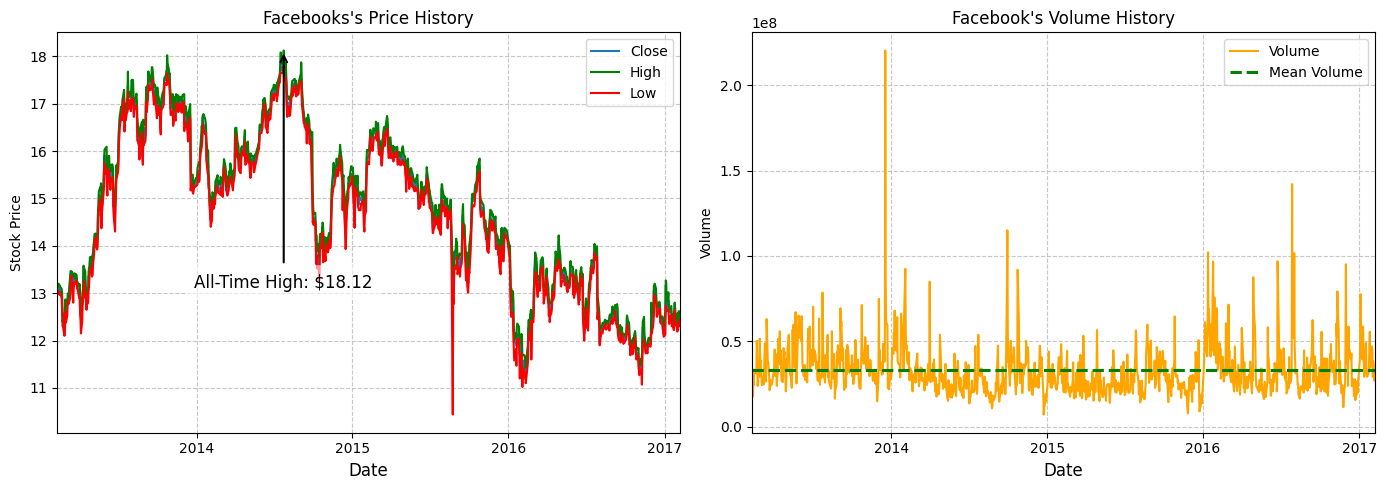

In [34]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Close, High, and Low Prices on ax1
ax1.plot(fb_train["date"], fb_train["close"], label="Close")
ax1.plot(fb_train["date"], fb_train["high"], color="green", label="High")
ax1.plot(fb_train["date"],fb_train["low"], color="red", label="Low")
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Stock Price")
ax1.set_title("Facebooks's Price History")
ax1.legend()

# Find the all-time high
all_time_high = fb_train["high"].max()
all_time_high_date = fb_train[fb_train["high"] == all_time_high]["date"].values[0]

# Annotate the all-time high (arrow pointing below)
ax1.annotate(
    f"All-Time High: ${all_time_high:.2f}",
    xy=(all_time_high_date, all_time_high),
    xytext=(all_time_high_date, all_time_high - 5),  # Place the text below
    arrowprops=dict(facecolor="black", arrowstyle="->", lw=1.5),
    fontsize=12,
    color="black",
    ha="center",
    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.5', alpha=0.6)  # Background for the text
)

# Volume on ax2
ax2.plot(fb_train["date"], fb_train["volume"], color="orange", label="Volume")
ax2.set_xlabel("Date", fontsize=12)
ax2.axhline(y=fb_train['volume'].mean(), linestyle='--', lw=2.2, color='green', label="Mean Volume")
ax2.set_ylabel("Volume")
ax2.set_title("Facebook's Volume History")
ax2.legend()

for ax in [ax1, ax2]:
    ax.xaxis.set_major_locator(mdates.YearLocator())  # Major ticks every year
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))  # Format as 'YYYY'
    ax.set_xlim([fb_train["date"].min(), fb_train["date"].max()])  # Limit to data range
    ax.grid(True, linestyle="--", alpha=0.7)  # Optional grid for clarity

plt.tight_layout()
plt.show()

Looking at Facebook's stock market history we can see a decling trend throughout the years with a massive crash in the middle of 2015.  Moving on to the `volume` history of Facebook, we can see that it also remained relatively stable, with some huge increases for some dates.

#### General Inference

We notice for all the scatterplots, we can see a massive stock crash near the middle of 2015.  We can attribute it to the 2015-201 [stock market selloff](https://en.wikipedia.org/wiki/2015%E2%80%932016_stock_market_selloff#:~:text=Stock%20market%20performance%20in%20mid%2D2015,-The%20DJIA%20closed&text=The%20stock%20market%20slowly%20slid,%24105%20by%20August%2021%2C%202015.), this is when the **SSE Composite Index** fell 43% in just over 2 months between June 2015 and August 2015 which devalued the currency of the Chinese yuian which scared investors into selling shares globally.  As shown visually above, we can see the most of the *S&P 500* companies suffered drastically from this event.

#### Key Observations

1. For our 5 companies we are analyzing, we have following companies:
   - **1 Bank: Bank Of America**
   - **3 Tech: Tesla, Apple, Facebook**
   - **1 Electrical: General Electric**

2. Facebook seems to be the only declining stock

3. Generel Electric, Apple, and Bank of America have an increasing stock market

4. Tesla has a relatively stable stock market

## Feature Engineering

#### Creating Daily Mean and Daily Return Features

Feature Engineering is crucial for uncovering possible hidden patterns in our dataset that our original dataframe does not have.  In the case of stock price forecasting, we can create two features `daily_mean` and `daily_return` which can be derived from our current features.  We can create the `daily_mean` feature by:

$$
\text{daily\_mean} = \frac{\text{Open} + \text{Close} + \text{High} + \text{Low}}{4}
$$

Which would essentially be averages of the stock price for that day.

We can create another feature `daily_return` by performing the following:

$$
\text{daily\_return} = \frac{\text{Close} - \text{Open}}{\text{Open}} \times 100
$$

This will can the percentage result for a specific day of the stock market.

We hope that by creating this features, we can help our model uncover hidden patterns that our main dataset might have missed.

#### Tesla Feature Engineer

In [35]:
# Calculate 'daily_mean' and 'daily_return' for the Tesla dataset
tesla_train['daily_mean'] = (tesla_train['open'] + tesla_train['close'] + tesla_train['high'] + tesla_train['low']) / 4
tesla_train['daily_return'] = ((tesla_train['close'] - tesla_train['open']) / tesla_train['open']) * 100

In [36]:
tesla_train.head()

,date,open,high,low,close,volume,daily_mean,daily_return
658,2013-02-08,7.890,8.000,7.828,7.848,5699000,7.8915,-0.532319
659,2013-02-11,7.596,7.830,7.500,7.684,16331500,7.6525,1.158504
660,2013-02-12,7.690,7.774,7.458,7.578,11306500,7.6250,-1.456437
661,2013-02-13,7.660,7.800,7.610,7.690,4834000,7.6900,0.391645
662,2013-02-14,7.728,7.750,7.642,7.654,4953500,7.6935,-0.957557


We will do the same with the testing set to ensure consistency and fairness in predictive modelling.

In [37]:
# Calculate 'daily_mean' and 'daily_return' for the Tesla dataset
tesla_test['daily_mean'] = (tesla_test['open'] + tesla_test['close'] + tesla_test['high'] + tesla_test['low']) / 4
tesla_test['daily_return'] = ((tesla_test['close'] - tesla_test['open']) / tesla_test['open']) * 100

#### S&P 500 Feature Engineer

Using our dictionary defined above which holds all the training and testing datasets, we can iterate through the non-telsa datasets to ensure that the new features are also correctly added.

In [38]:
# List of dataset names to process
non_tesla_dataset_names = ["bac_train", "apple_train", "fb_train", "ge_train", "bac_test", "apple_test", "fb_test", "ge_test"]

# Loop through the datasets and calculate 'daily_mean' and 'daily_return'
for name in non_tesla_dataset_names:
    # Access the DataFrame by name (assuming the datasets are stored in variables)
    df = globals()[name]  # Get the DataFrame object by its variable name
    
    # Ensure the DataFrame is not empty
    if not df.empty:
        # Explicitly create a copy to avoid SettingWithCopyWarning
        df = df.copy()
        
        # Calculate daily_mean and daily_return
        df['daily_mean'] = (df['open'] + df['close'] + df['high'] + df['low']) / 4
        df['daily_return'] = ((df['close'] - df['open']) / df['open']) * 100
        
        # Update the original variable
        globals()[name] = df


apple_train.head()

,date,open,high,low,close,volume,Name,daily_mean,daily_return
1259,2013-02-08,67.7142,68.4014,66.8928,67.8542,158168416,AAPL,67.715650,0.206751
1260,2013-02-11,68.0714,69.2771,67.6071,68.5614,129029425,AAPL,68.379250,0.719832
1261,2013-02-12,68.5014,68.9114,66.8205,66.8428,151829363,AAPL,67.769025,-2.421264
1262,2013-02-13,66.7442,67.6628,66.1742,66.7156,118721995,AAPL,66.824200,-0.042850
1263,2013-02-14,66.3599,67.3771,66.2885,66.6556,88809154,AAPL,66.670275,0.445600


### Comparative Analysis of Tech Companies

- An important aspect of Financial and Investmental Stock Analysis is the comparison of stocks among the same sector.  The most efficient way to conduct analysis of different ratios like Earnings per share (EPS), Price-to-Earnings (P/E Ratio), Return on Equity (ROE), Return on Capital Employed (ROCE), and Debt-to-Equity ratios, and stock-prices of various companies, trade volume of stocks.
- Due to the limited data of companies, we can only compare daily mean stock price of companies and can make inferences like stock price comparison and relative stock price fluctuations that I have mentioned below chart.

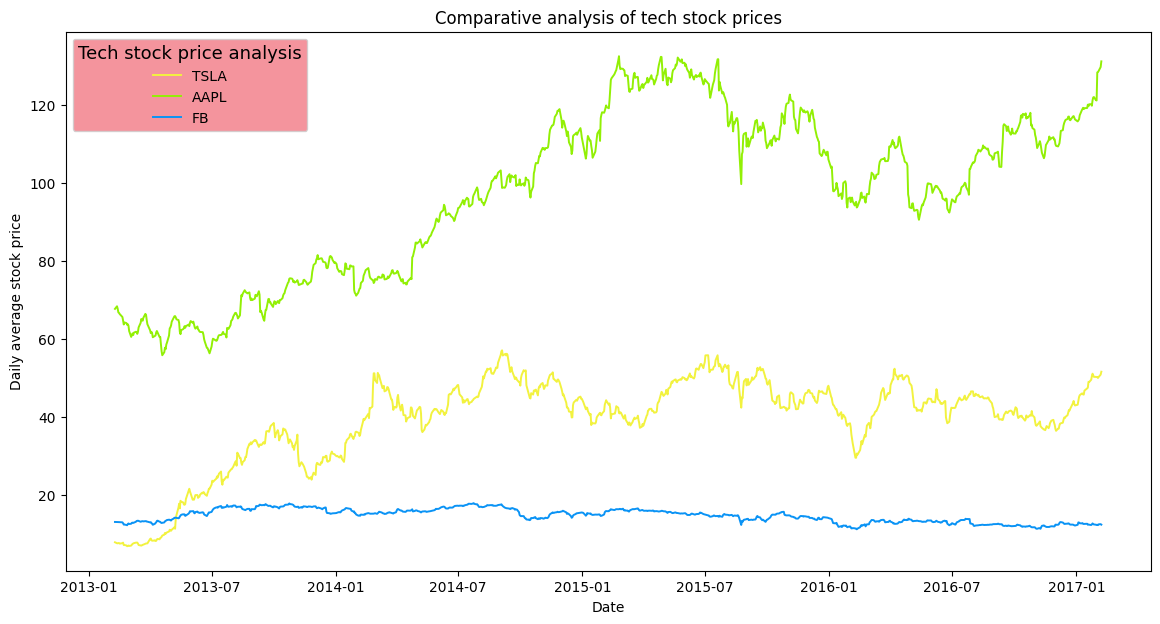

In [39]:
# tech stocks price comparison
fig, ax = plt.subplots(figsize=(14,7))
ax.plot(tesla_train['date'], tesla_train['daily_mean'],label='TSLA', color='#f2f23f', lw=1.4)
ax.plot(apple_train['date'], apple_train['daily_mean'],label='AAPL', color='#92f005', lw=1.4)
ax.plot(fb_train['date'], fb_train['daily_mean'],label='FB', color='#0a93f5', lw=1.4)
ax.set_title("Comparative analysis of tech stock prices")
ax.set_xlabel("Date")
ax.set_ylabel("Daily average stock price")
ax.legend(facecolor='#f27985', fontsize="medium", title="Tech stock price analysis", title_fontsize=13)

plt.show()

##### Observations

- **Apple is one of the most expensive stock among the 3 tech companies**
- **Facebook was among the cheapest to buy compared to other stock**
- **The above tech stocks seem to vary in average stock price**

#### Observing Trend of Daily Returns Over Time

Since we have feature engineered the feature `daily_return` which measures the daily return of a given stock, we can graph out a line plot which shows the percentage change over time.  The feature `daily_return` can be: **postive, zero, or negative**.  With positive values representing increase in stock price, negative values representing a decrease in stock price, and zero representing no change in the stock price.

We can also look for the **period of volatility** within the graph.  The **period of volatility** is the period of time where the market's asset price changes quickly and significantly.

**Volatility** is a statistical measurement of how spread out data is around its mean over a period of time. In finance, it's used to describe how spread out market prices are over a given period of time.

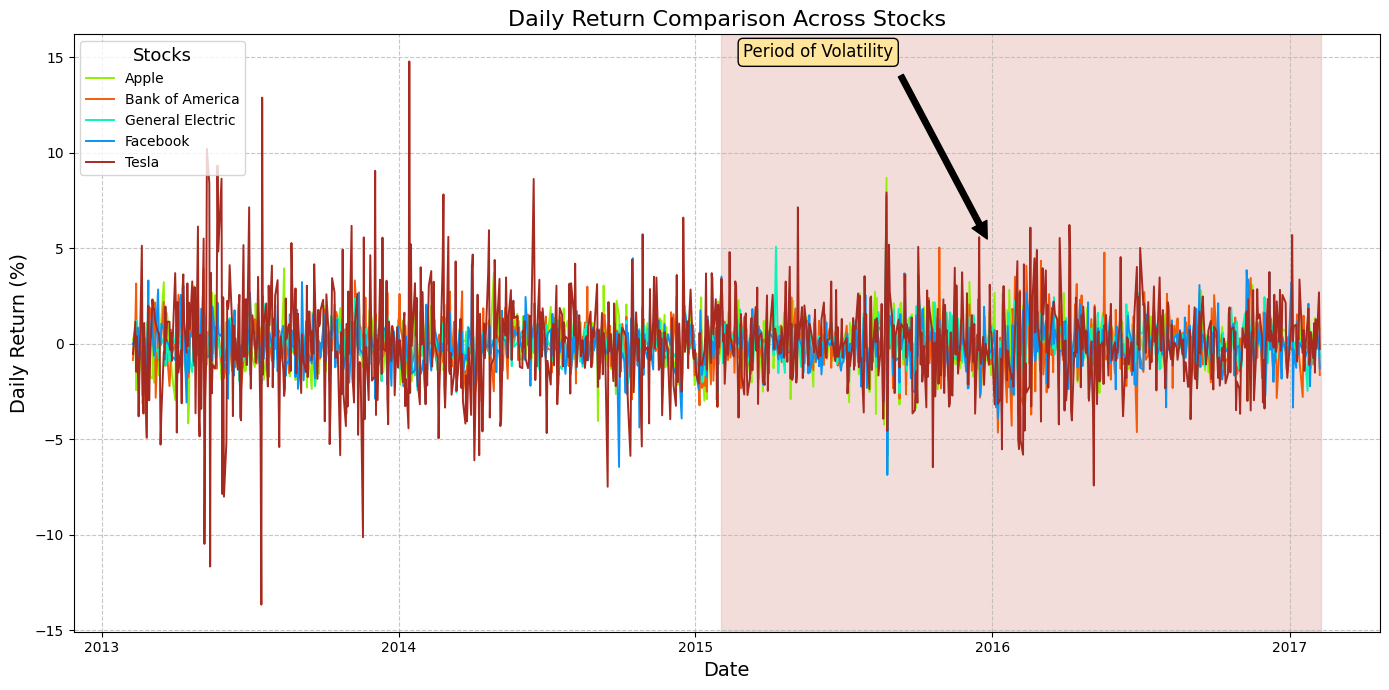

In [40]:
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(apple_train['date'], apple_train['daily_return'], label="Apple", color="#92f005", lw=1.4)
ax.plot(bac_train['date'], bac_train['daily_return'], label="Bank of America", color="#f55c0a", lw=1.4)
ax.plot(ge_train['date'], ge_train['daily_return'], label="General Electric", color="#0af5ba", lw=1.4)
ax.plot(fb_train['date'], fb_train['daily_return'], label="Facebook", color="#0a93f5", lw=1.4)
ax.plot(tesla_train['date'], tesla_train['daily_return'], label="Tesla", color="#A72A20", lw=1.4)

ax.axvspan(*mdates.datestr2num(['2015-02-01', '2017-02-08']), color='#e3aaa6', alpha=0.4)

# Annotation with a box
ax.annotate(
    "Period of Volatility",
    xy=(mdates.datestr2num('2016-01-01'), 5),  # Coordinates to place the annotation
    xytext=(mdates.datestr2num('2015-06-01'), 15),  # Offset text for better visibility
    arrowprops=dict(facecolor='black', shrink=0.05),
    bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="#ffe69c"),
    fontsize=12,
    ha="center",
)

ax.set_title("Daily Return Comparison Across Stocks", fontsize=16)
ax.set_xlabel("Date", fontsize=14)
ax.set_ylabel("Daily Return (%)", fontsize=14)

# Formatting the x-axis for dates
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.grid(True, linestyle="--", alpha=0.7)

# Add a legend
ax.legend(loc="upper left", fontsize="medium", title="Stocks", title_fontsize=13)

# Show the plot
plt.tight_layout()
plt.show()

From the line plot, we can see that the **Period of Volatility** appears from `2015-2017`.  This is the area where the stock market fluctuated significantly for our our datasets in this study.  We can interpret this period as the period where investors should have more fears and uncertainty and their stock prediction as it can lead to significant losses or gains.

The **Volatility Period** is also the period where most day-traders prefer trading as they offer more oppprotunities for large swings in market price.  In contrast, the time period where there is low volatility is where long-term investors prefer trading because it offers steady gains over time.

#### Percentage Growth of Stock Prices

- In financial and investment analysis, stock price growth is an important metric to view as one needs to measure how a certain stock or investment of a portfolio is growing.

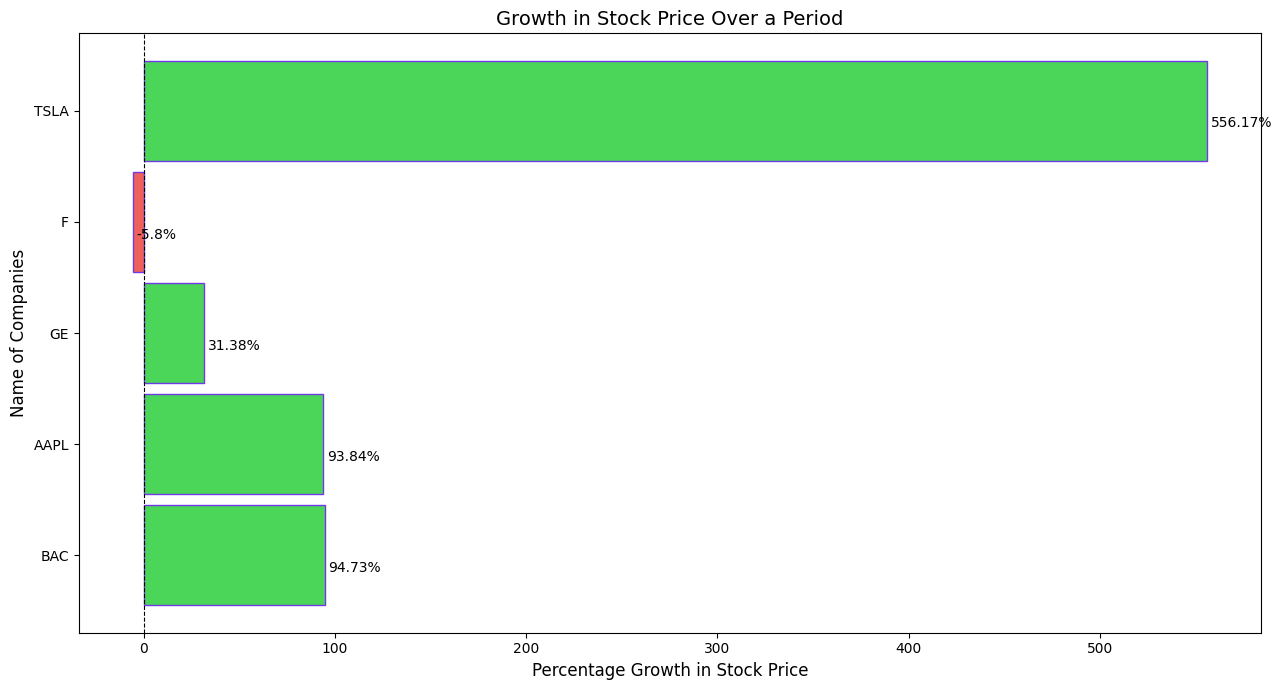

In [41]:
tesla_train['Name'] = "TSLA"
tesla_test['Name'] = "TSLA"

# List of stock DataFrames (including Tesla)
list_df = [bac_train, apple_train, ge_train, fb_train, tesla_train]

# Loop through the datasets to calculate the necessary metrics
mini = [df[df['date'] == df['date'].min()]['close'].values.item() for df in list_df]
maxi = [df[df['date'] == df['date'].max()]['close'].values.item() for df in list_df]

# Calculate the absolute difference and percentage growth
diff = np.array(maxi) - np.array(mini)
growth = (diff / np.array(mini)) * 100
growth_list = growth.tolist()

# Extract company names
co_name_list = [df['Name'].unique()[0] for df in list_df]

# Visualize the growth of the stocks
fig, ax = plt.subplots(figsize=(13, 7))
colors = ['#4bd659' if g > 0 else '#ed615c' for g in growth_list]  # Dynamic color based on growth
ax.barh(y=co_name_list, width=growth_list, height=0.9, color=colors, edgecolor='#713ae8')

# Annotate each bar with the percentage growth value
for p in ax.patches:
    ax.annotate(f'{round(p.get_width(), 2)}%', (p.get_width() + 2, p.get_y() + 0.3), fontsize=10)

# Add labels and title
ax.set_xlabel('Percentage Growth in Stock Price', fontsize=12)
ax.set_ylabel('Name of Companies', fontsize=12)
ax.set_title("Growth in Stock Price Over a Period", fontsize=14)
ax.axvline(0, color='black', linestyle='--', linewidth=0.8)  # Add a vertical line at 0 for reference

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

#### Observations

- We can see from the graph that `TSLA` has the highest stock growth among all the other 4 datasets present over a 5 year period of time with a significant **556.17%** return
- Facebook has been given a negative return over the 5 year period of time.

## Daily Return Simple Hypothesis Test

We can conduct a simple hypothesis test using python's `scipy.stats` module.  It has a method called `ttest_1samp` which we will use to generate the p value

When we want to make an investment in the stock market, we expect to buy the dip since we usually expect the stock price to rise back up, thus potentially profitting from a temporary market downturn and having an increasing daily return for a small instance of time.  In some cases,  you will often hear that the stock market doesn't generate any profits, thus indicating a 0% `daily_return` in a singular day.

We can conduct a simple hypothesis test by analyzing our 5 datasets and assessing their `daily_return` distribution

<div style="text-align: center;">
    $H_0$: daily_return = 0 <br>
    $H_A$: daily_return $\neq$ 0
</div>


We will now prove this hypothesis as a one sample t-test as we know population mean but are not aware of standard deviation.  With a significance level $\alpha$ = 0.05, we will reject $H_0$ if and only if our **p-value** < 0.05.

In [42]:
from scipy import stats

#list of stock dataframes
datasets = [tesla_train, bac_train, apple_train, ge_train, fb_train]

result_dict = {}
for df in datasets:
    result = stats.ttest_1samp(df['daily_return'], 0)
    result_dict[df['Name'].unique()[0]] = result   
result_dict

{'TSLA': TtestResult(statistic=0.3796641169588079, pvalue=0.7042748907809526, df=1006),
 'BAC': TtestResult(statistic=-0.5338929014702957, pvalue=0.5935335809655882, df=1006),
 'AAPL': TtestResult(statistic=0.2682136588657254, pvalue=0.7885898481214841, df=1006),
 'GE': TtestResult(statistic=0.9023965145803321, pvalue=0.36706227800039737, df=1006),
 'F': TtestResult(statistic=-1.4630315511591672, pvalue=0.14377109485575376, df=1006)}

Observations
- From the above results, we learn that all of their **p-values** are above 0.05, thus we can not reject the null and conclude that the `daily_return = 0` with a significance level of $\alpha$= 0.05
- Statistically speaking, it indicates that all the datasets have a `daily_return` of 0 percent which is the most general case for all stocks

## Forecasting Methods

### Creating Lagged Features

We will be now trying to forecast the future stock price. The function below is adapted from [UBC CPSC 330](https://ubc-cs.github.io/cpsc330-2024W1/lectures/notes/19_intro_to_computer-vision.html) , with some improvements.

In [43]:
def create_lag_feature_single(df, orig_feature, lag, new_feature_name=None, clip=False):
    """
    Creates a lagged version of an existing feature for a single time series.

    Parameters
    ----------
    df : pandas.core.frame.DataFrame
        The dataset.
    orig_feature : str
        The column name of the feature we're copying.
    lag : int
        The lag; negative lag means values from the past, positive lag means values from the future.
    new_feature_name : str
        Override the default name of the newly created column.
    clip : bool
        If True, remove rows with NaN values for the new feature.

    Returns
    -------
    pandas.core.frame.DataFrame
        A new DataFrame with the additional lagged column.
    """
    if new_feature_name is None:
        if lag < 0:
            new_feature_name = f"{orig_feature}_lag{-lag}"
        else:
            new_feature_name = f"{orig_feature}_ahead{lag}"
    
    # Add the new lagged column
    df[new_feature_name] = df[orig_feature].shift(-lag)

    # Clip rows with NaN values if requested
    if clip:
        df = df.dropna(subset=[new_feature_name])

    return df

We need to first make sure the datasets are sorted by `Date`, however, this is already ensured as shown near the beginnings of the dataset, therefore no code has to be done.

<br>
<br>

Now we will be **lagging** the `close` feature of the datasets and make a new feature `close_tom`.  This will the `close` price of tomorrows stock market.  We have `clip=True` to remove for any missing values, however this is not needed as we do not have any missing variables in our dataset.

### Tesla Lagged Feature

In [44]:
tesla_train = tesla_train.sort_values(by="date")

In [45]:
# Lag the Close price by 1 day
tesla_train = create_lag_feature_single(
    tesla_train,
    orig_feature="close",
    lag=1,  # Lagging by 1 day into the past
    new_feature_name = "close_tom",
    clip = True
)

tesla_train

,date,open,high,low,close,volume,daily_mean,daily_return,Name,close_tom
658,2013-02-08,7.890000,8.000000,7.828000,7.848000,5699000,7.891500,-0.532319,TSLA,7.684000
659,2013-02-11,7.596000,7.830000,7.500000,7.684000,16331500,7.652500,1.158504,TSLA,7.578000
660,2013-02-12,7.690000,7.774000,7.458000,7.578000,11306500,7.625000,-1.456437,TSLA,7.690000
661,2013-02-13,7.660000,7.800000,7.610000,7.690000,4834000,7.690000,0.391645,TSLA,7.654000
662,2013-02-14,7.728000,7.750000,7.642000,7.654000,4953500,7.693500,-0.957557,TSLA,7.408000
...,...,...,...,...,...,...,...,...,...,...
1659,2017-01-31,49.848000,51.178001,49.540001,50.386002,20580500,50.238001,1.079285,TSLA,49.848000
1660,2017-02-01,50.610001,50.639999,49.810001,49.848000,19794000,50.227000,-1.505633,TSLA,50.310001
1661,2017-02-02,49.667999,50.484001,49.542000,50.310001,12499000,50.001000,1.292587,TSLA,50.265999
1662,2017-02-03,50.382000,50.436001,49.936001,50.265999,10933500,50.255000,-0.230243,TSLA,51.554001


For the same reasons listed above, we will also be lagging the datasets of the testing splits.

In [46]:
# Lagging the testing set
tesla_test = create_lag_feature_single(
    tesla_test,
    orig_feature = "close",
    lag = 1,
    new_feature_name = "close_tom",
    clip = True
)

Plotting the time series graph by splitting the dataset gives us:

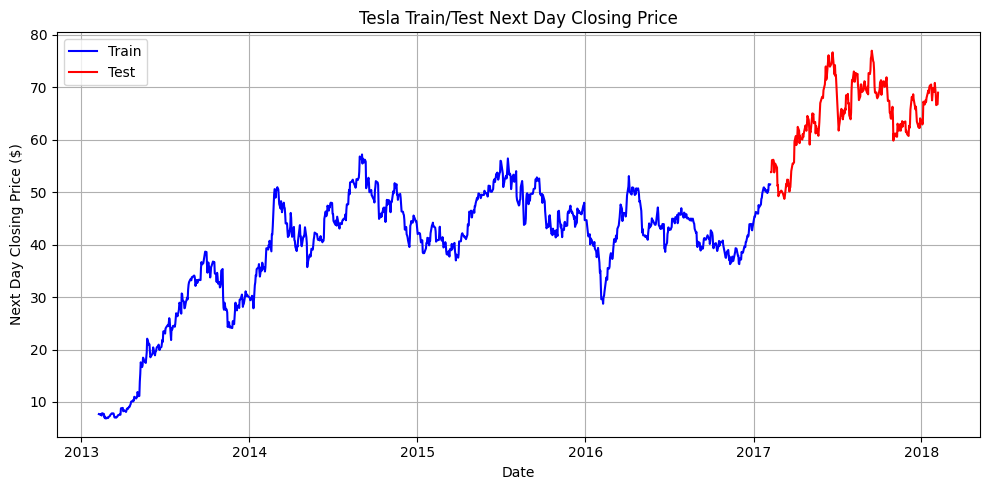

In [47]:
# Plot Tesla's train/test close_tom values
plt.figure(figsize=(10, 5))

# Plot train data
plt.plot(tesla_train['date'], tesla_train['close_tom'], label='Train', color='blue')

# Plot test data
plt.plot(tesla_test['date'], tesla_test['close_tom'], label='Test', color='red')

# Formatting the plot
plt.xlabel('Date')
plt.ylabel('Next Day Closing Price ($)')
plt.title('Tesla Train/Test Next Day Closing Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### S&P 500 Lagged Features

We will now do the same for the S&P 500 training and testing splits.

In [48]:
#non_tesla_dataset_names = ["bac_train", "apple_train", "fb_train", "ge_train", "bac_test", "apple_test", "fb_test", "ge_test"]

for name in non_tesla_dataset_names:
    df = globals()[name]
    if not df.empty:
        df = df.copy()
        create_lag_feature_single(
            df,
            orig_feature = "close",
            lag = 1,
            new_feature_name = "close_tom",
            clip = True
        )
        globals()[name] = df.dropna()

apple_train.head()

,date,open,high,low,close,volume,Name,daily_mean,daily_return,close_tom
1259,2013-02-08,67.7142,68.4014,66.8928,67.8542,158168416,AAPL,67.715650,0.206751,68.5614
1260,2013-02-11,68.0714,69.2771,67.6071,68.5614,129029425,AAPL,68.379250,0.719832,66.8428
1261,2013-02-12,68.5014,68.9114,66.8205,66.8428,151829363,AAPL,67.769025,-2.421264,66.7156
1262,2013-02-13,66.7442,67.6628,66.1742,66.7156,118721995,AAPL,66.824200,-0.042850,66.6556
1263,2013-02-14,66.3599,67.3771,66.2885,66.6556,88809154,AAPL,66.670275,0.445600,65.7371


We can also plot out the forecast charts for the S&P500 Datasets similarily to that of the Tesla

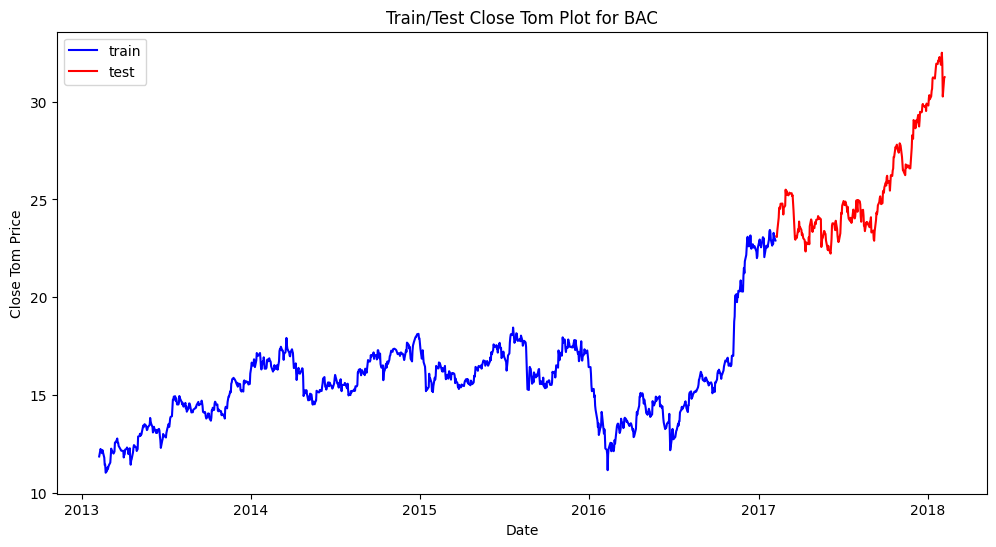

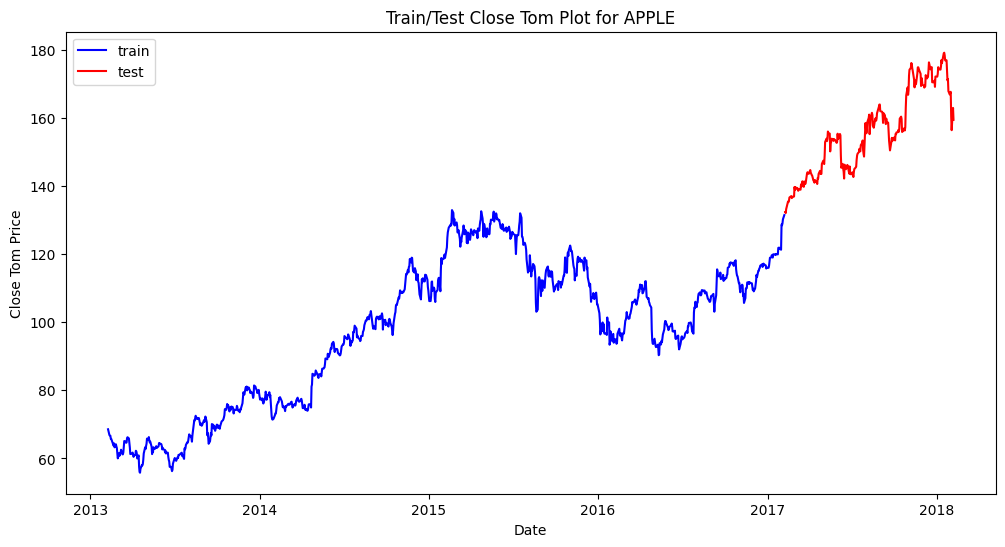

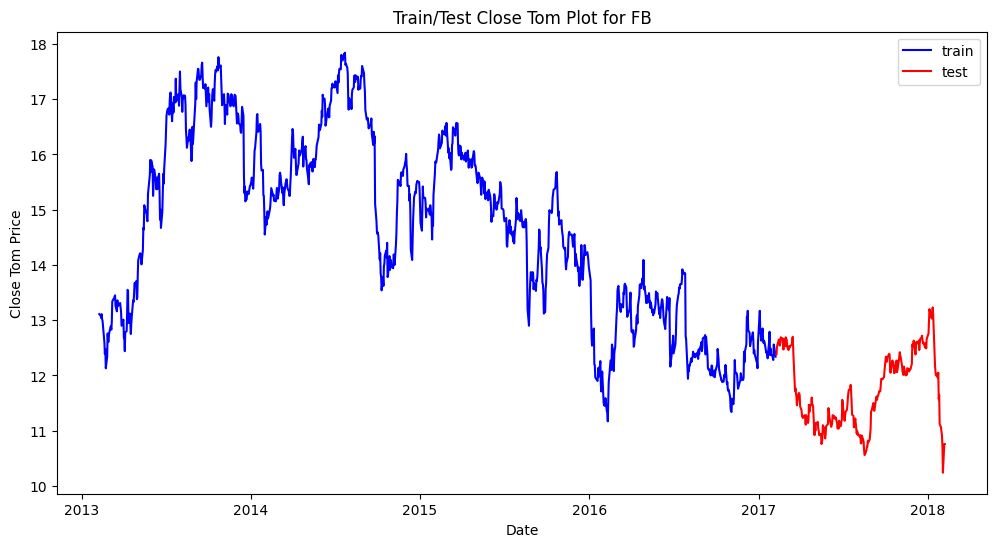

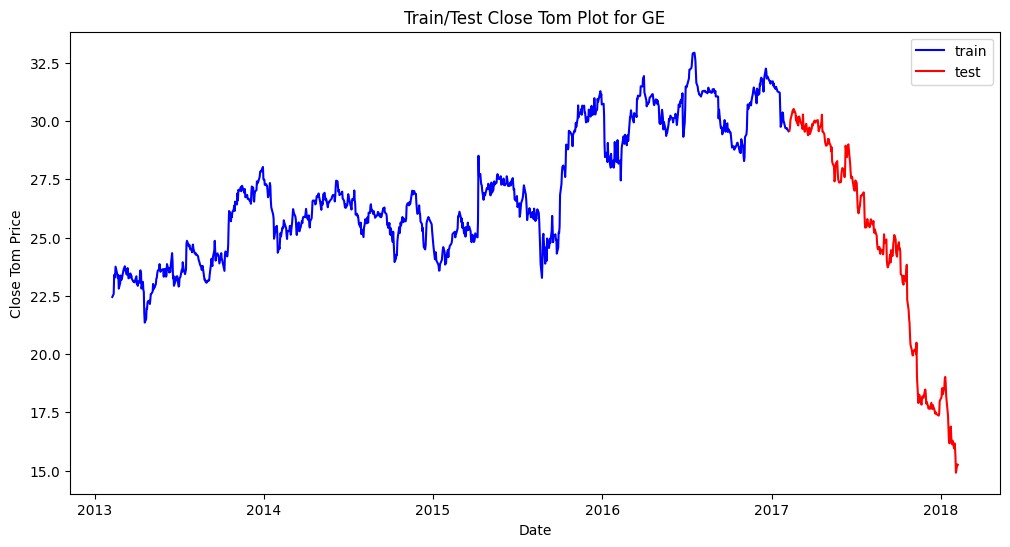

In [49]:
# List of dataset names (ensure these DataFrames are defined in your environment)
non_tesla_dataset_names = [
    "bac_train", "bac_test", 
    "apple_train", "apple_test", 
    "fb_train", "fb_test", 
    "ge_train", "ge_test"
]

# Dictionary to map dataset names to their actual DataFrame objects
datasets = {
    "bac_train": bac_train,
    "bac_test": bac_test,
    "apple_train": apple_train,
    "apple_test": apple_test,
    "fb_train": fb_train,
    "fb_test": fb_test,
    "ge_train": ge_train,
    "ge_test": ge_test
}

# Generate plots iteratively for each pair of train and test datasets
for name in ["bac", "apple", "fb", "ge"]:
    train_df = datasets[f"{name}_train"]
    test_df = datasets[f"{name}_test"]

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(train_df["date"], train_df["close_tom"], label="train", color="blue")
    plt.plot(test_df["date"], test_df["close_tom"], label="test", color="red")
    plt.title(f"Train/Test Close Tom Plot for {name.upper()}")
    plt.xlabel("Date")
    plt.ylabel("Close Tom Price")
    plt.legend()
    plt.show()

## Creating A Baseline Model

For our predictive forecasting project, if we are to build any model, we would need to compare against something.  Normally we would use something like a `DummyRegressor` or a `DummyClassifier` as a baseline.  In this case, since we are working with time series analysis, we will use another method.  We will assume that the price stays the same from yesterday; thus we will set our prediction of `close_tom` exactly equal to our value of `close`, which indicates no change.

An interpretation of this could be "The final closing price of the stock market is the final closing price of the stock market today"

### R2 Score

We will be using the **coefficient of determination** or better known as **R2** score to measure the accuracy of our model.

The **$R^2$** score is a statistical measurement that indicates how well a model predicts an outcome.  It ranges from 0 to 1, with 0 being the worst possible value and 1 being the best. A higher **$R^2$** value indicates a better fit for the data.

Interpretation:
1. $R^2$ = 0; 0% of the variation in the dependent variable can be explained by the independent variable
2. $R^2$ = 1; 100% of the variation in the dependent variable can be explained by the independent variable

#### Tesla R2 Training Score

In [50]:
tesla_train_r2 = None

tesla_train_r2 = r2_score(tesla_train["close_tom"], tesla_train["close"])

tesla_train_r2

0.9902638787971879

#### Tesla R2 Test Score

In [51]:
tesla_test_r2 = None

tesla_test_r2 = r2_score(tesla_test["close_tom"], tesla_test["close"])

tesla_test_r2

0.951874682268901

#### S&P 500 Training Score

In [52]:
non_tesla_train_dataset_names = ["bac_train", "apple_train", "fb_train", "ge_train"]
r2_scores = {}

for dataset_name in non_tesla_train_dataset_names:
    df = eval(dataset_name)
    if "close_tom" in df.columns and "close" in df.columns:
        r2_scores[dataset_name] = r2_score(df["close_tom"], df["close"])
    else:
        r2_scores[dataset_name] = None 

# Print the R2 scores
for name, score in r2_scores.items():
    print(f"{name} R2 Score: {score}")

bac_train R2 Score: 0.98760157219361
apple_train R2 Score: 0.995060934372568
fb_train R2 Score: 0.9844436269305595
ge_train R2 Score: 0.987264864386323


#### S&P 500 Testing Score

In [53]:
non_tesla_test_dataset_names = ["bac_test", "apple_test", "fb_test", "ge_test"]
r2_scores = {}

for dataset_name in non_tesla_test_dataset_names:
    df = eval(dataset_name)
    if "close_tom" in df.columns and "close" in df.columns:
        r2_scores[dataset_name] = r2_score(df["close_tom"], df["close"])
    else:
        r2_scores[dataset_name] = None 

# Print the R2 scores
for name, score in r2_scores.items():
    print(f"{name} R2 Score: {score}")

bac_test R2 Score: 0.9827090543276045
apple_test R2 Score: 0.976266669113813
fb_test R2 Score: 0.9526813554207765
ge_test R2 Score: 0.9951262808581152


#### Interpretation and Problems

It seems that our R2 scores are very high, as most of our training and test scores are above 0.95 which can be interpretted as 95%+ of the variation can be explained by the independent variable.

This can be in a sense, be not that helpful as if the dummy model is better, there is no point in making a new model and some of the R2 scores we have to beat seem very high.  Lets utilize some models like the `RandomForestRegressor` and see whether the R2 scores vary.

### Apply the RandomForestRegressor

We first need to preprocess/scale the data so there isnt any biases when applying the model to our datasets

In [54]:
numeric_features     = ["open", "high", "low", "volume", "daily_mean", "daily_return"]
categorical_features = []
keep_features        = ["close"]
drop_features        = ["date", "Name"] 
target_feature       = "close_tom"

Next, we make the `preprocess_features` function adapted from UBC CPSC 330, with a minor modification to allow un-transformed features via `keep_features`:

In [55]:
def preprocess_features(df_train, df_test, 
                        numeric_features, 
                        categorical_features, 
                        keep_features, 
                        drop_features, 
                        target_feature):
    
    all_features = numeric_features + categorical_features + keep_features + drop_features + [target_feature]
    if set(df_train.columns) != set(all_features):
        print("Missing columns", set(df_train.columns) - set(all_features))
        print("Extra columns", set(all_features) - set(df_train.columns))
        raise Exception("Columns do not match")
        
    # Put the columns in the order we want
    df_train = df_train[all_features]
    df_test = df_test[all_features]
    
    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(drop='first'))
    ])
    preprocessor = ColumnTransformer([
        ('numeric', numeric_transformer, numeric_features),
        ('categorical', categorical_transformer, categorical_features),
        ('passthrough', 'passthrough', keep_features),
        ('drop', 'drop', drop_features + [target_feature])
    ])
    preprocessor.fit(df_train)

    if len(categorical_features) > 0:
        ohe = preprocessor.named_transformers_['categorical'].named_steps['onehot']
        ohe_feature_names = list(ohe.get_feature_names_out(categorical_features))
        new_columns = numeric_features + ohe_feature_names + keep_features
    else:
        new_columns = numeric_features + keep_features

    # Transform data and construct new DataFrames
    X_train_enc = pd.DataFrame(data=preprocessor.transform(df_train), index=df_train.index, columns=new_columns)
    X_test_enc = pd.DataFrame(data=preprocessor.transform(df_test), index=df_test.index, columns=new_columns)
    
    y_train = df_train[target_feature]
    y_test = df_test[target_feature]
    
    return X_train_enc, y_train, X_test_enc, y_test

In [56]:
tesla_train_enc, tesla_y_train, tesla_test_enc, tesla_y_test = preprocess_features(tesla_train, tesla_test, 
                        numeric_features, 
                        categorical_features, 
                        keep_features, 
                        drop_features, 
                        target_feature)

In [57]:
tesla_train_enc.head()

,open,high,low,volume,daily_mean,daily_return,close
658,-2.791427,-2.820013,-2.761454,-1.114862,-2.794652,-0.218124,7.848
659,-2.817453,-2.834945,-2.790790,-0.641915,-2.815841,0.436333,7.684
660,-2.809132,-2.839863,-2.794547,-0.865433,-2.818279,-0.575816,7.578
661,-2.811787,-2.837579,-2.780952,-1.153338,-2.812516,0.139510,7.690
662,-2.805768,-2.841971,-2.778090,-1.148023,-2.812206,-0.382718,7.654


#### Tesla RandomForestRegressor

Since we are not scaling `close_tom`, we are also not scaling `close` either which might help with predicition accuracy.  Alternatively, we can also predict whether the change was positive/negative or predict the daily_return of the stock market.

Making the `RandomForestRegressor` model, we begin by below (this can be better optimized with hyper-parameter optimization):

In [58]:
rfr = RandomForestRegressor(n_estimators=10, max_depth=5, random_state=42)

In [59]:
rfr.fit(tesla_train_enc, tesla_y_train)

RandomForestRegressor(max_depth=5, n_estimators=10, random_state=42)

In [60]:
rfr.score(tesla_train_enc, tesla_y_train)

0.9921449868862594

In [61]:
rfr.score(tesla_test_enc, tesla_y_test)

-1.830888716780061

For the `RandomForestRegressor`, we got an R2 score of 0.997 for the training set which is slightly better than our baseline R2, however, when applied to the testing set, we get a negative R2 value, which indicates that our model predicts significantly worse on the testing set.

Lets do an Example on an S&P 500 dataset, to see if we get the same problem as above.

#### S&P 500 RandomForestRegressor

#### Bank of America

In [62]:
bac_train_enc, bac_y_train, bac_test_enc, bac_y_test = preprocess_features(bac_train, bac_test, 
                        numeric_features, 
                        categorical_features, 
                        keep_features, 
                        drop_features, 
                        target_feature)

In [63]:
bac_train_enc.head()

,open,high,low,volume,daily_mean,daily_return,close
72870,-1.721454,-1.760451,-1.724840,1.041736,-1.743878,-0.654697,11.760
72871,-1.779291,-1.760451,-1.747212,0.124439,-1.752785,0.896562,11.860
72872,-1.717005,-1.565504,-1.697994,2.944926,-1.633097,2.526929,12.245
72873,-1.503450,-1.530059,-1.577188,2.080944,-1.549037,-1.143038,12.170
72874,-1.619126,-1.596518,-1.568239,1.012811,-1.596912,0.278569,12.130


In [64]:
rfr.fit(bac_train_enc, bac_y_train)

RandomForestRegressor(max_depth=5, n_estimators=10, random_state=42)

In [65]:
rfr.score(bac_train_enc, bac_y_train)

0.9898831238038117

In [66]:
rfr.score(bac_test_enc, bac_y_test)

-0.9242143957152436

Testing it on the Bank of America Dataset, we see that we get a 0.99 R2 score while a negative test score, meaning that the data has significantly overfit on our model and performs significantly worse on the testing set.  This of course is a problem, which indicates that we might need to switch our evaluation methodology.  From our R2 score, we can not lag features to accurately predict the stock market as the model can not uncover patterns that is good for model deployment.

Theoretically, we could have two datasets which don't work well with the forecasting method, however I want an evaluation method which forecasts high-quality data for all my datasets included

## Alternative Methodology: Prophet

**Prophet** is a forecasting model made by Facebook's research team.  It provides an easier implementation of time-series forecasting and utilizes Scikit-Learn api's.

We will ultilize this methodology to make high-quality forecasts that can keep up with our dataset size.

In [67]:
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

Lets first recombine all of our train/test split data to make it into one

#### Tesla

In [68]:
tesla_dat = pd.concat([tesla_train, tesla_test], axis=0, ignore_index=True)
tesla_dat = tesla_dat.drop(columns=["close_tom"])


tesla_dat.head()

,date,open,high,low,close,volume,daily_mean,daily_return,Name
0,2013-02-08,7.890,8.000,7.828,7.848,5699000,7.8915,-0.532319,TSLA
1,2013-02-11,7.596,7.830,7.500,7.684,16331500,7.6525,1.158504,TSLA
2,2013-02-12,7.690,7.774,7.458,7.578,11306500,7.6250,-1.456437,TSLA
3,2013-02-13,7.660,7.800,7.610,7.690,4834000,7.6900,0.391645,TSLA
4,2013-02-14,7.728,7.750,7.642,7.654,4953500,7.6935,-0.957557,TSLA


#### S&P 500 Datasets

In [69]:
bac_dat = pd.concat([bac_train, bac_test], axis=0, ignore_index=True)
bac_dat = bac_dat.drop(columns=["close_tom"])

apple_dat = pd.concat([apple_train, apple_test], axis=0, ignore_index=True)
apple_dat = apple_dat.drop(columns=["close_tom"])

fb_dat = pd.concat([fb_train, fb_test], axis=0, ignore_index=True)
fb_dat = fb_dat.drop(columns=["close_tom"])

ge_dat = pd.concat([ge_train, ge_test], axis=0, ignore_index=True)
ge_dat = ge_dat.drop(columns=["close_tom"])

### Hypothesis Test with Full Dataset

Since we created a full dataset which includes test/train splits, lets conduct a simple hypothesis test by analyzing our 5 datasets again and assessing their `daily_return` distribution to see if anything has changed

<div style="text-align: center;">
    $H_0$: daily_return = 0 <br>
    $H_A$: daily_return $\neq$ 0
</div>


We will now prove this hypothesis as a one sample t-test as we know population mean but are not aware of standard deviation.  With a significance level $\alpha$ = 0.05, we will reject $H_0$ if and only if our **p-value** < 0.05.

In [70]:
#We will use both the train/test split since we are using their sample population mean 

#list of stock dataframes
datasets = [tesla_dat, bac_dat, apple_dat, ge_dat, fb_dat]

result_dict = {}
for df in datasets:
    result = stats.ttest_1samp(df['daily_return'], 0)
    result_dict[df['Name'].unique()[0]] = result   
result_dict

{'TSLA': TtestResult(statistic=0.4876369916743734, pvalue=0.6258920920115312, df=1256),
 'BAC': TtestResult(statistic=-0.3259197490546495, pvalue=0.7445393646331053, df=1256),
 'AAPL': TtestResult(statistic=0.4485950401017377, pvalue=0.6538011916333069, df=1256),
 'GE': TtestResult(statistic=-0.6611019445476124, pvalue=0.5086681834129074, df=1256),
 'F': TtestResult(statistic=-1.8029210667300046, pvalue=0.07164021941466181, df=1256)}

As indicated by the p-values, even with the full included datasets, we see that we fail to reject the $H_0$ for all datasets and conclude that the `daily_return` of these datasets = 0.

**No effective statistical change** has been made with the inclusion of the full dataset.

## Forecasting Using Prophet

**Prophet** is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

We first need to preprocess the dataframe so prophet can work with the data.

In [71]:
# create function to return dataframe for forecating
def df_formatting(df):
    df = df.loc[:, ['date','close']]
    df.rename(columns={'date':'ds', 'close':'y'}, inplace=True)
    
    return df

tesla_ph_dat = df_formatting(tesla_dat)
bac_ph_dat = df_formatting(bac_dat)
apple_ph_dat = df_formatting(apple_dat)
fb_ph_dat = df_formatting(fb_dat)
ge_ph_dat = df_formatting(ge_dat)

Then we make the model by declaring `prophet`.  We can also generate the confidence intervals for the predictions and plot the forecast

In [72]:
# forecasting using prophet
def price_forecasting(df, period):
    
    prophet = Prophet(yearly_seasonality = 'auto')
    prophet.fit(df)
    future_price = prophet.make_future_dataframe(periods=period)
    forecasts = prophet.predict(future_price)
    forecast = forecasts[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
    
    # plot the foreasts
    fig = prophet.plot(forecasts)
    a = add_changepoints_to_plot(fig.gca(), prophet, forecasts)
    
    # plot the components 
    fig2 = prophet.plot_components(forecasts)
    
    return forecasts

## Tesla Stock Price Forecast

01:59:18 - cmdstanpy - INFO - Chain [1] start processing
01:59:18 - cmdstanpy - INFO - Chain [1] done processing


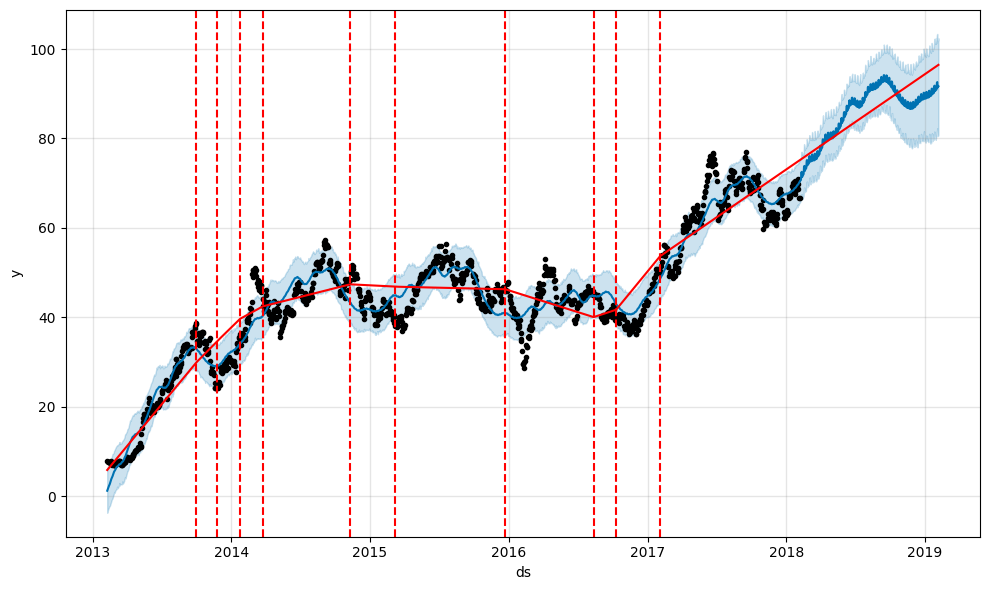

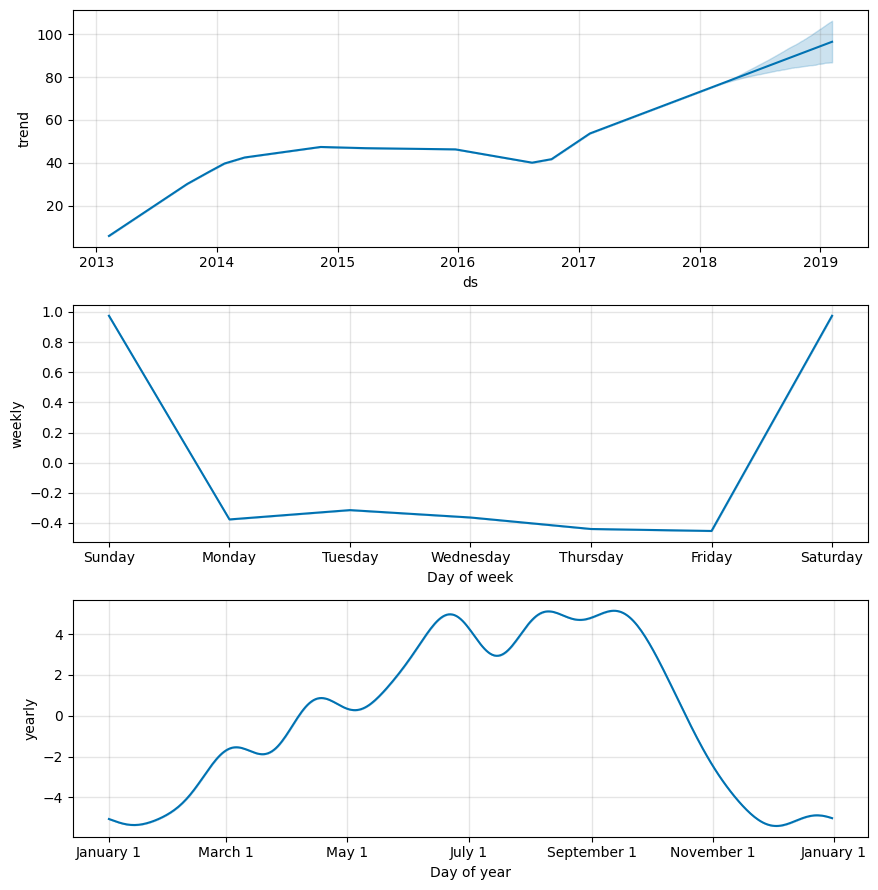

In [73]:
forecast_tesla = price_forecasting(tesla_ph_dat, 365)

Observations:
- Our model forecasts tesla stock to go up to around $90 a share next year
- Our stock price tends to go up on weekends
- The month between May and September are when we expect the stock price to rise most significantly

## Bank Of America Stock Forecast

01:59:20 - cmdstanpy - INFO - Chain [1] start processing
01:59:20 - cmdstanpy - INFO - Chain [1] done processing


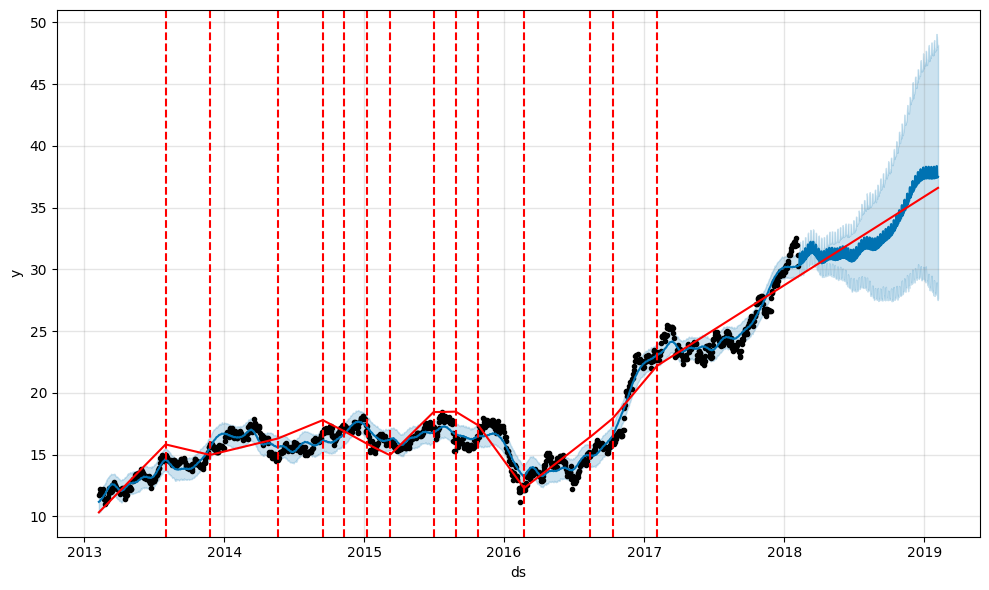

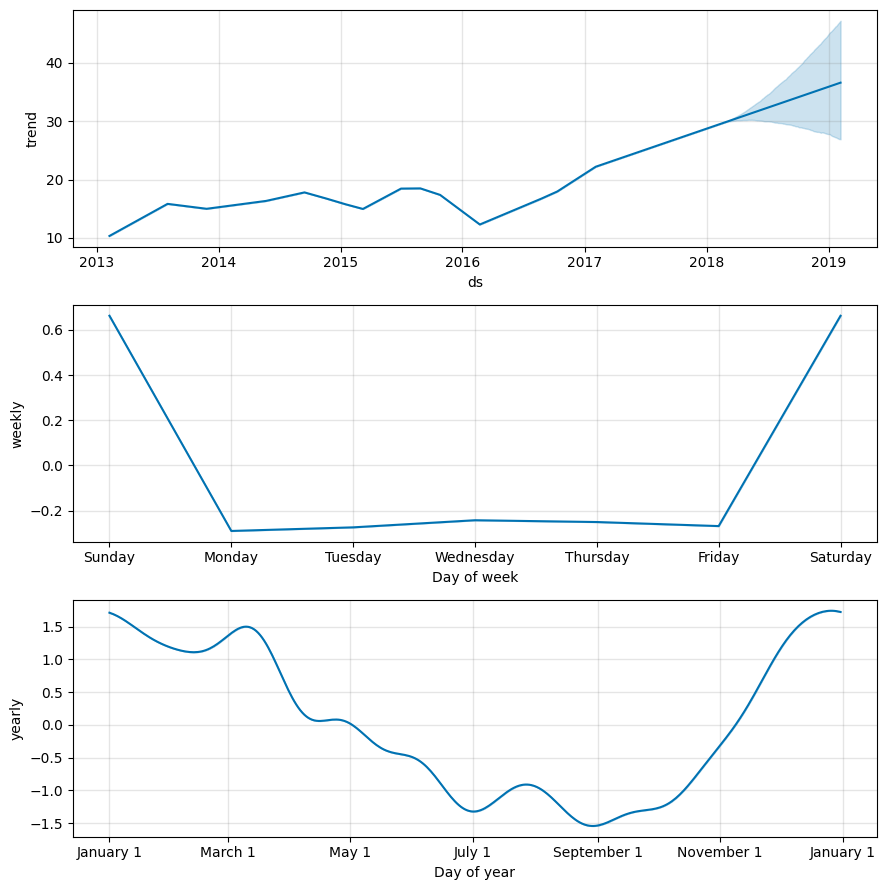

In [74]:
forecast_bac = price_forecasting(bac_ph_dat, 365)

Observations
- Our model forecasts BAC stocks to increase to around $37 next year
- The weekends are when we expect the stock price to increase the most
- From mid-November to mid-March are when we the stock prices to rise

## Apple Stock Forecast

01:59:22 - cmdstanpy - INFO - Chain [1] start processing
01:59:22 - cmdstanpy - INFO - Chain [1] done processing


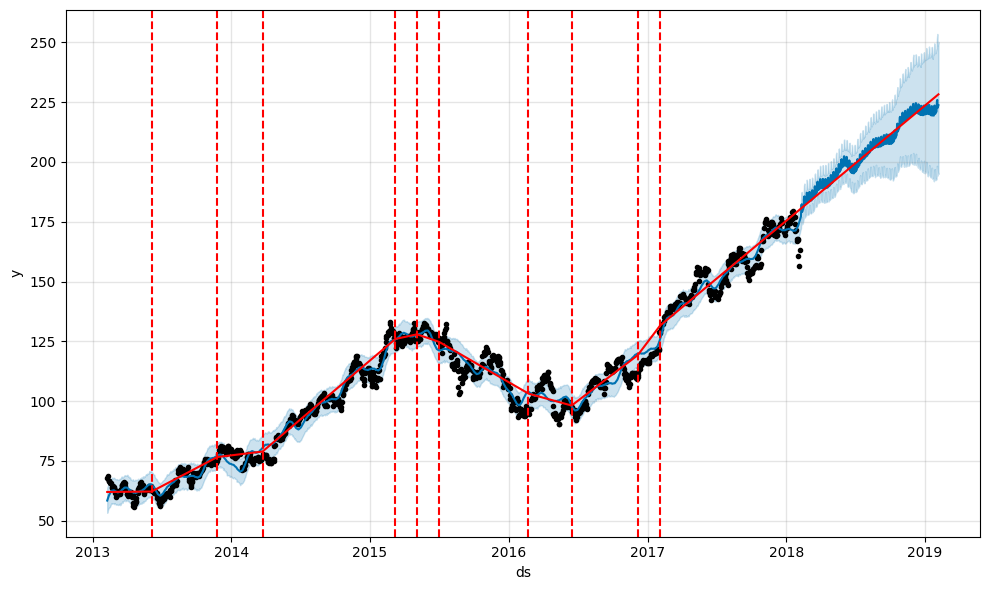

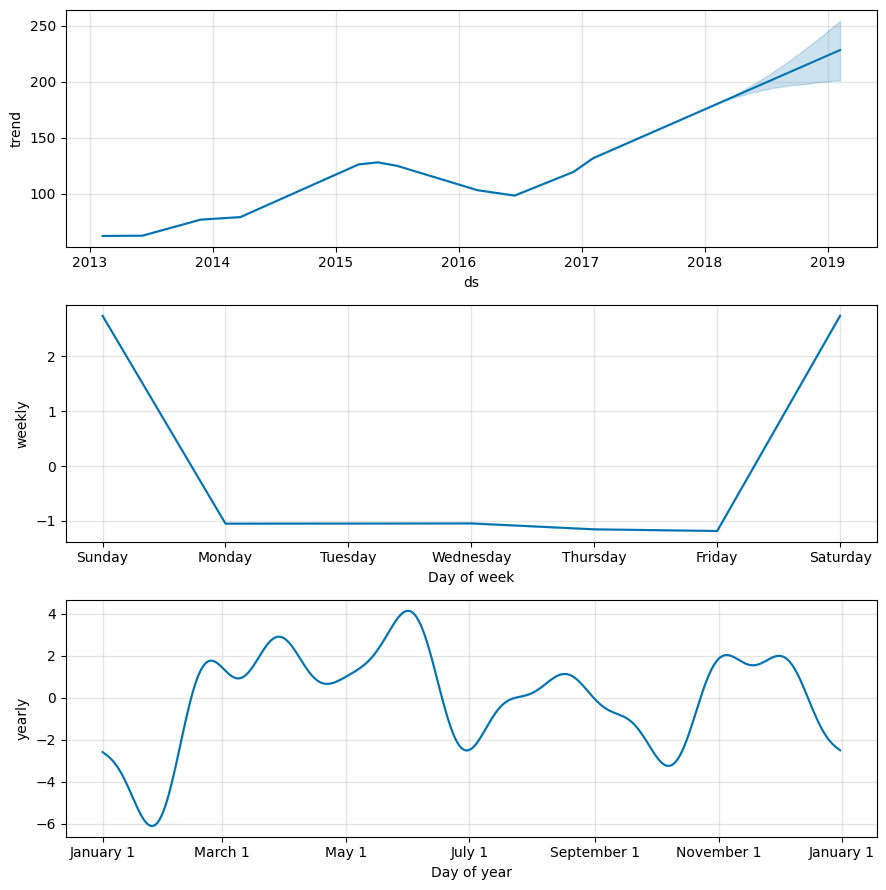

In [75]:
forecast_apple = price_forecasting(apple_ph_dat, 365)

Observations
- Our model predicts Apple's stock price to increase to around $221 next year
- The weekends are when our model expects our stock market to rise
- Our model predicts the months of March, May, and November to have the most increases to stock price

## Facebook Stock Forecast

01:59:23 - cmdstanpy - INFO - Chain [1] start processing
01:59:24 - cmdstanpy - INFO - Chain [1] done processing


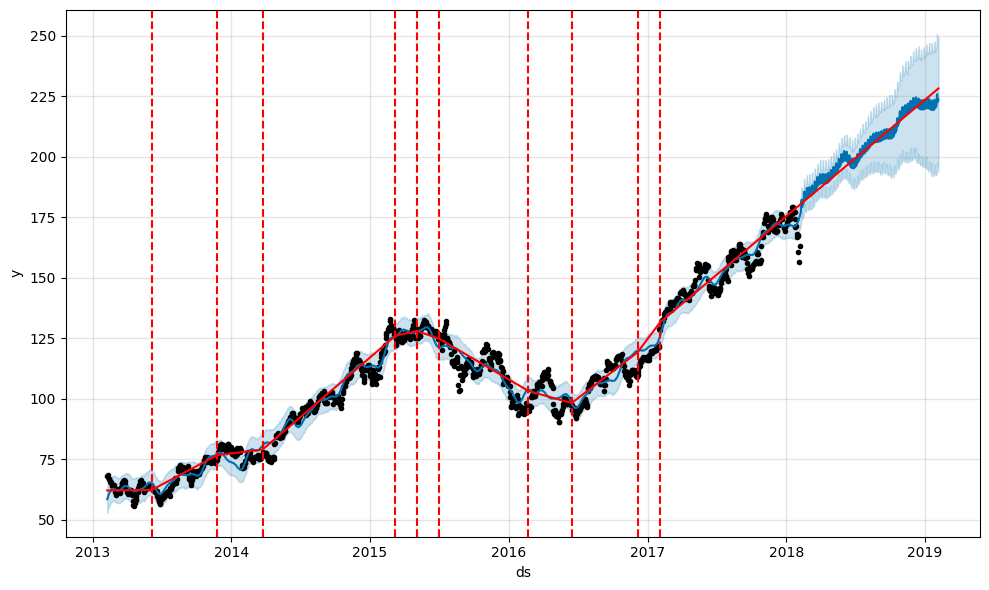

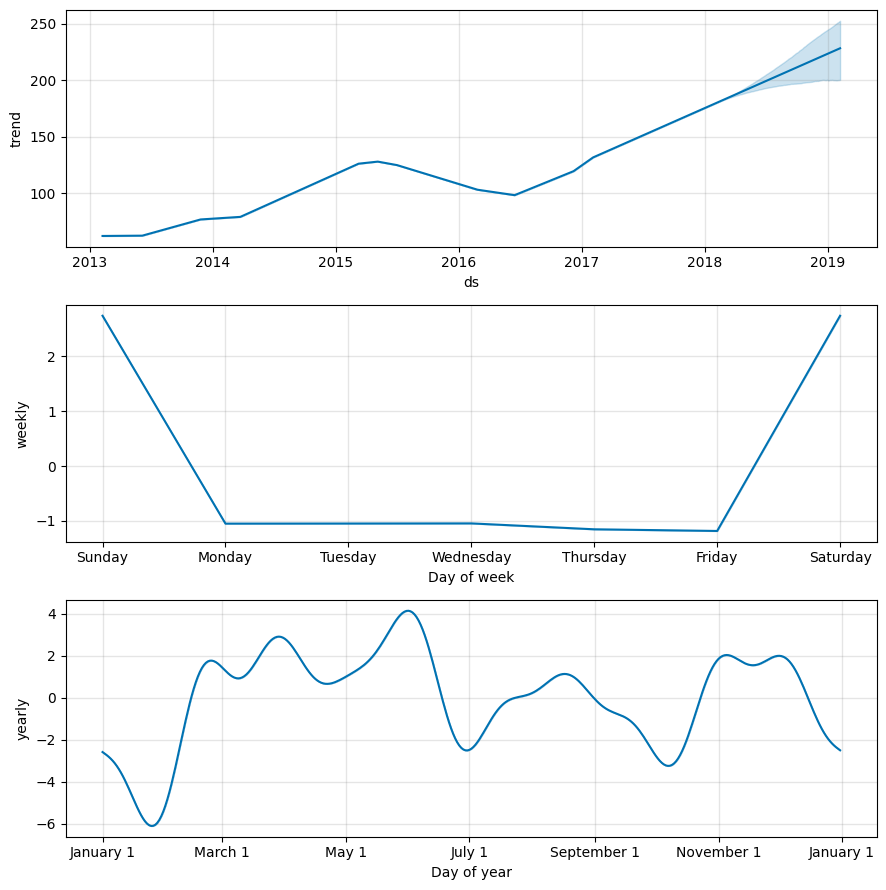

In [76]:
forecast_fb = price_forecasting(apple_ph_dat, 365)

Observations
- Our model predicts the stock of Facebook to increase to approximate $227 next year
- The weekend is when our model expects our stock price to rise the most
- the model suggests that in the months of March, mid May, mid July, and November; the stock price will increase in that time

## General Electric Stock Forecast

01:59:25 - cmdstanpy - INFO - Chain [1] start processing
01:59:25 - cmdstanpy - INFO - Chain [1] done processing


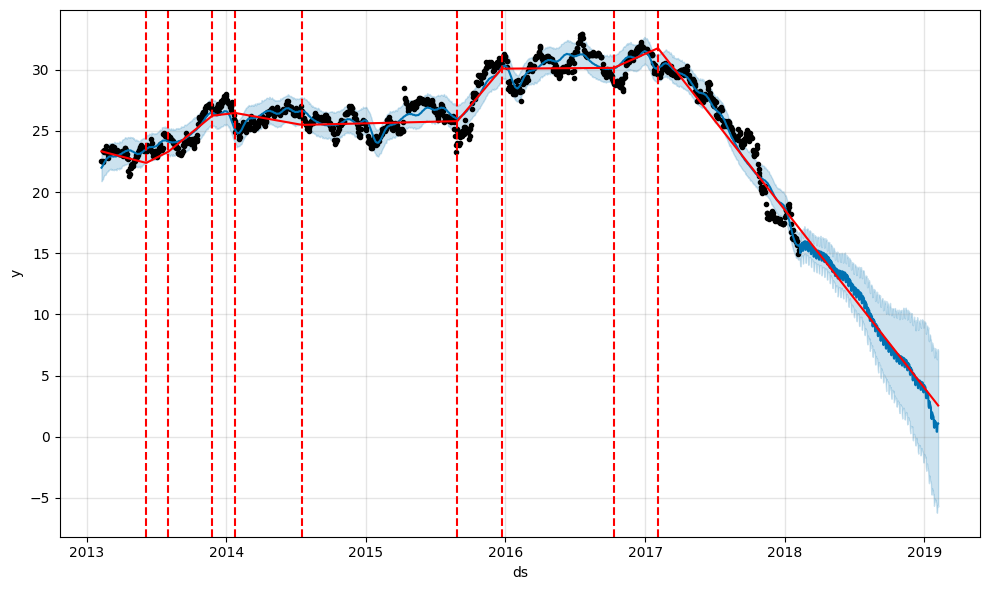

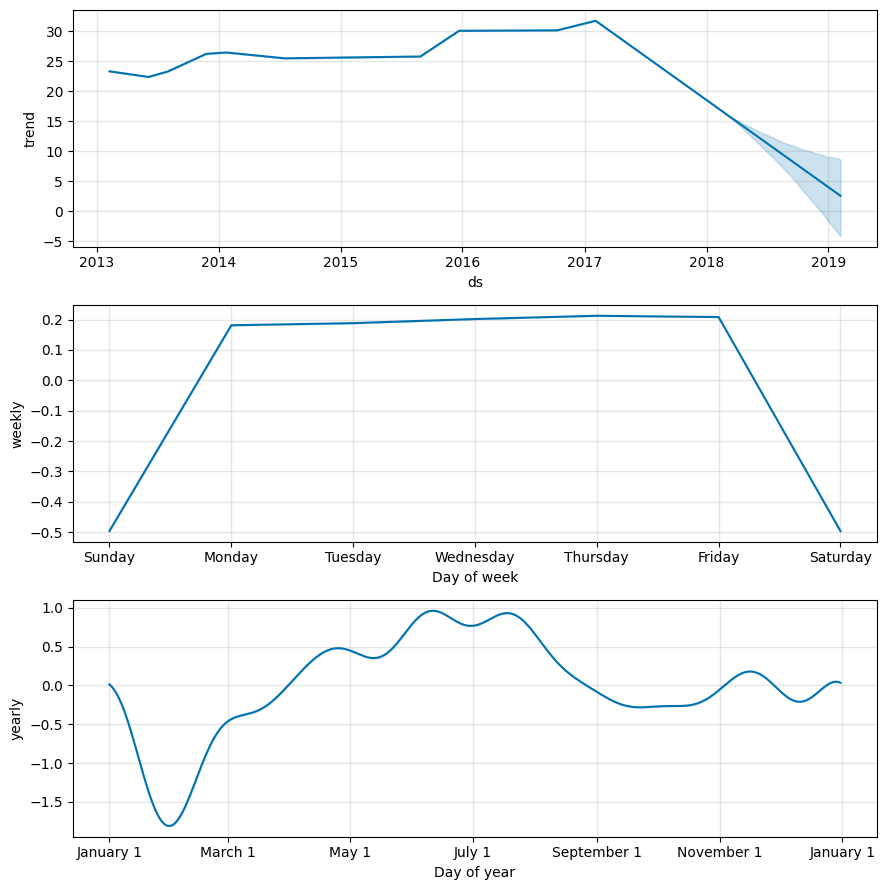

In [77]:
forecast_ge = price_forecasting(ge_ph_dat, 365)

Observations
- Our model predicts the final stock price of General Electric to decrease to approximately $2 next year
- The stock price tends to increase on the weekdays for General Electric
- we expect the stock price to increase between the months of May to September

## Alternative Method: Auto-ARIMA Models

Another model we can use to forecast our data is the **Auto ARIMA** (Auto-Regressive Integrated Moving Average) Model.  It is a statistical forecasting method commonly used for time series data.  It automates the process of identifying the best-fitting ARIMA model, by selecting optimal values for the key parameters.

The Auto ARIMA is widely used in finance, economics, and supply chain forecasting to predict metrics like stock prices, sales, and demand.  It also simplifies the model selection process (for those without deep statistical knowledge).

To begin, we first need to begin **Time-series decomposition**.  The involvement of thinking of a series as a combination of level, trend, seasonality, and noise components.  This will help provide us a useful abstract model for thinking about time series generally and for better understanding of problems during time series analysis and forecasting.

In [78]:
from statsmodels.tsa.seasonal import seasonal_decompose
#let's find seasonla decomposition of time-series models
def decomposition(df, period):
    # decompistion instance
    result_decom = seasonal_decompose(df['y'], model="additive", 
                                      period=period, extrapolate_trend='freq')
    # plot the componenets 
    fig = result_decom.plot()
    fig.set_size_inches((10, 6))
    # Tight layout to realign things
    fig.tight_layout()
    plt.show()
    
    # capture the compoenets 
    trend = result_decom.trend
    season = result_decom.seasonal
    reside = result_decom.resid
    return trend, season, reside

### Tesla Time-Series Decomposition

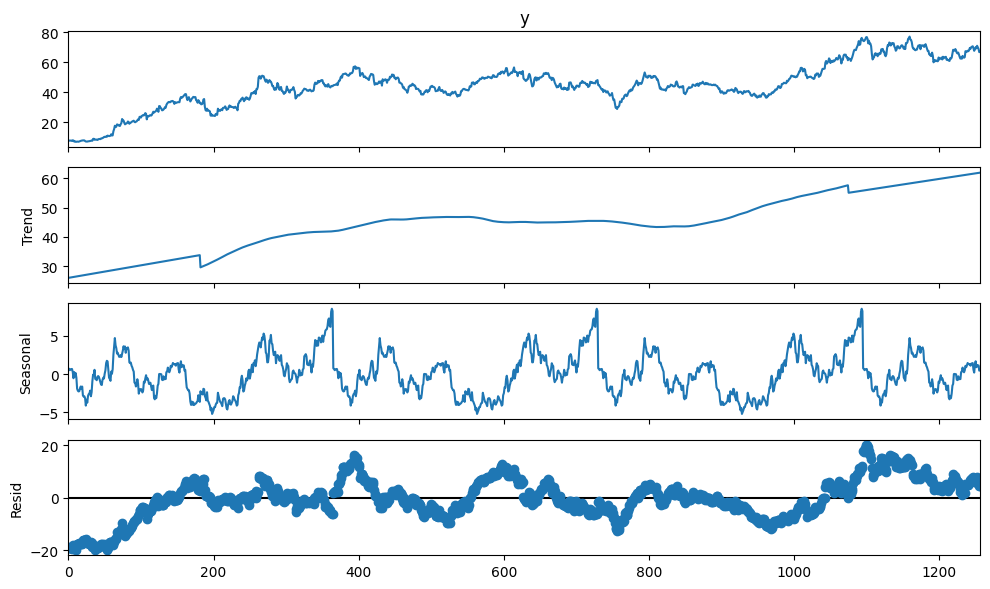

In [79]:
#Finding components for apple stock price, trend, seasonal trend, and residuals analyzed
tesla_tr, tesla_se, tesla_re = decomposition(tesla_ph_dat, 365)

### Bank of America Time-Series Decomposition

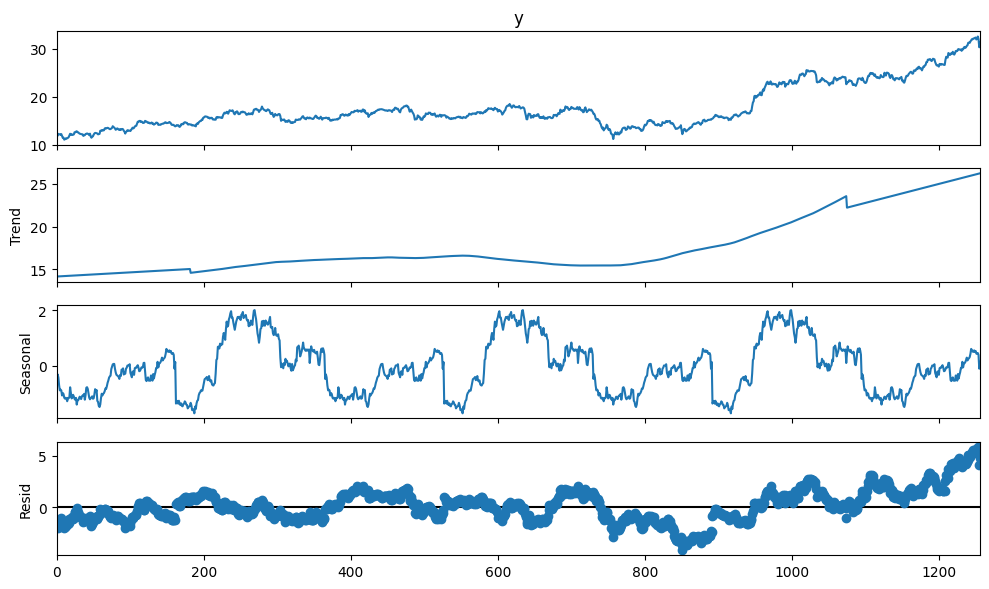

In [80]:
#Finding components for apple stock price, trend, seasonal trend, and residuals analyzed
bac_tr, bac_se, bac_re = decomposition(bac_ph_dat, 365)

### Apple Time-Series Decomposition

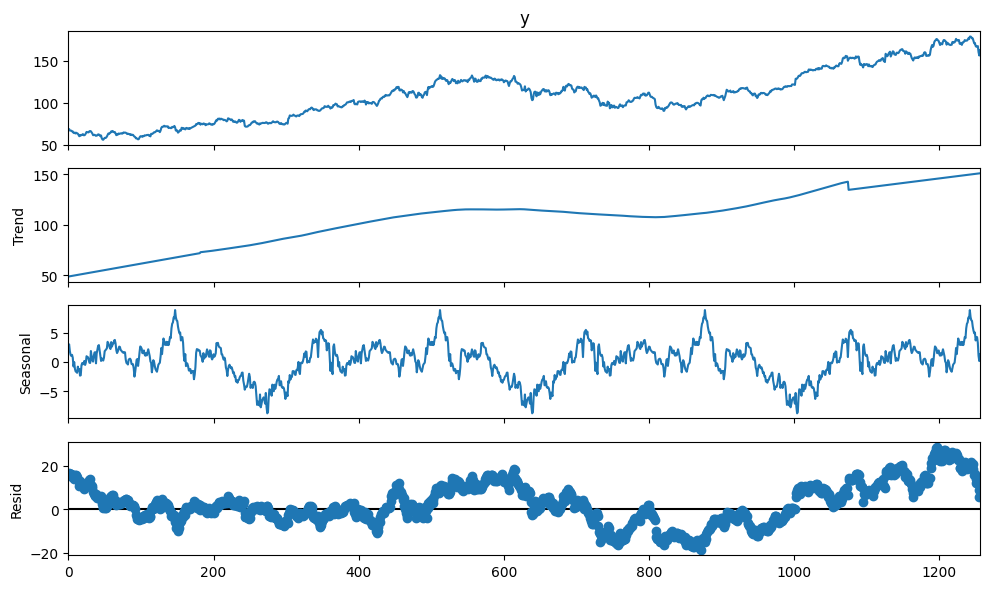

In [81]:
#Finding components for apple stock price, trend, seasonal trend, and residuals analyzed
apple_tr, apple_se, apple_re = decomposition(apple_ph_dat, 365)

### Facebook Time-Series Decomposition

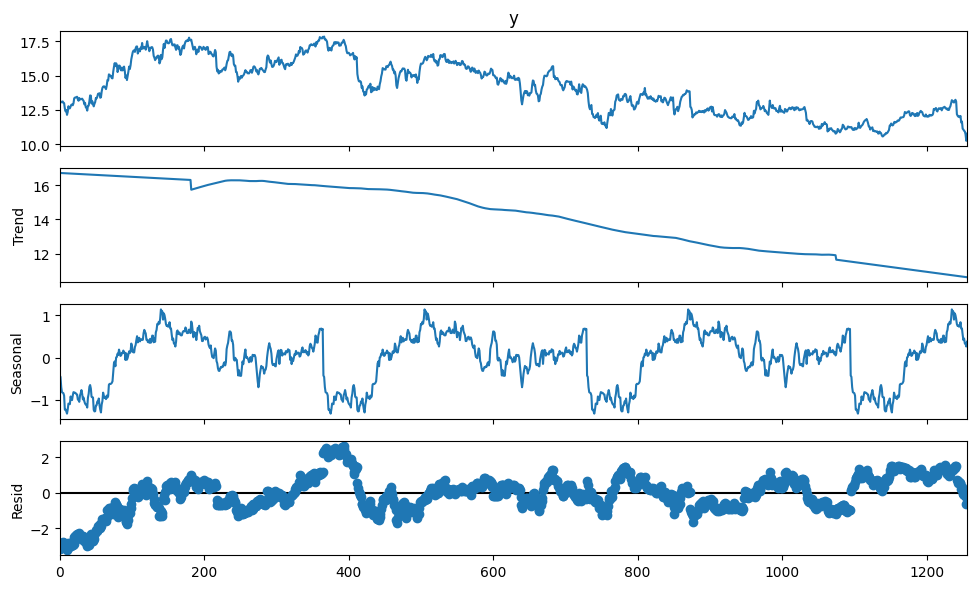

In [82]:
#Finding components for apple stock price, trend, seasonal trend, and residuals analyzed
fb_tr, fb_se, fb_re = decomposition(fb_ph_dat, 365)

### General Electric Time-Series Decomposition

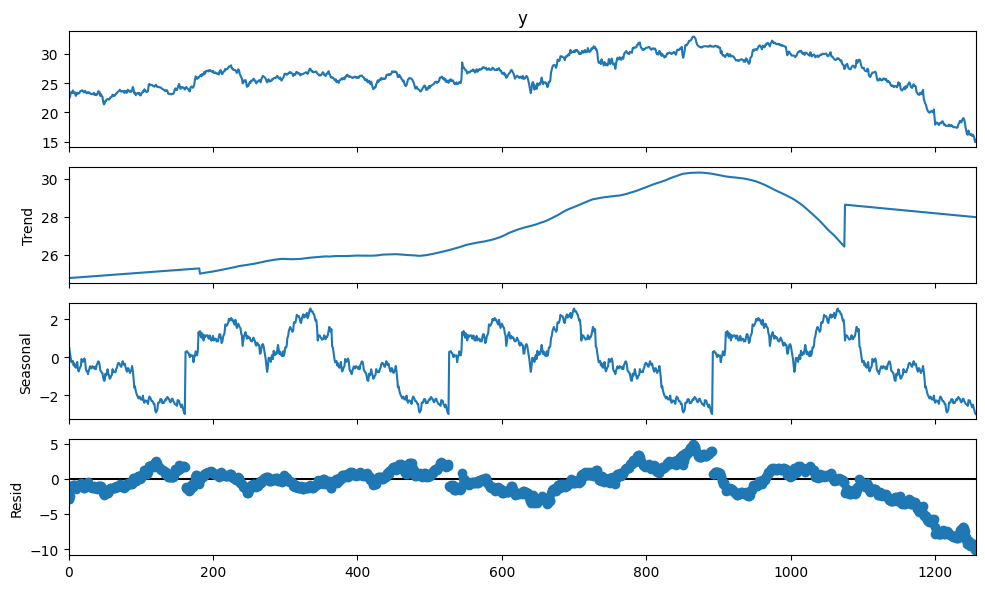

In [83]:
#Finding components for apple stock price, trend, seasonal trend, and residuals analyzed
ge_tr, ge_se, ge_re = decomposition(ge_ph_dat, 365)

### Plotting Autocorrelation and Partial Autocorrelation Plots for Inference

We first define a function which utilises `statsmodels` to create **ACF** and **PACF** plots.

**ACF**: Autocorrelation Function measures the correlation between the time series and a lagged version of itself.  It utilizes the parameter of passed lagged lengths and helps us identifyt the MA (moving average) terms in an ARIMA model

**PACF**: Partial Autocorrelation Function measures the correlation between a time series and a lagged version of itself *while accounting for the values of the intervals between*.  PACF plots can help us identify the AR (autoregressive) terms in an ARIMA model.

Both plots are widely used in many time series analysis to forecast a variety of data; they are also ready for inference once generated

In [84]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# function to return acf and pacf plots
def acf_pacf(df, lags):
    var = df['y']
    # plot the acf plot
    fig = plot_acf(var, lags=lags)
    fig.set_size_inches((9, 5))
    fig.tight_layout()
    plt.show()
    
    # plot the pacf plots
    fig = plot_pacf(var, lags=lags)
    fig.set_size_inches((9,5))
    fig.tight_layout()
    plt.show()

#### Tesla ACF and PACF

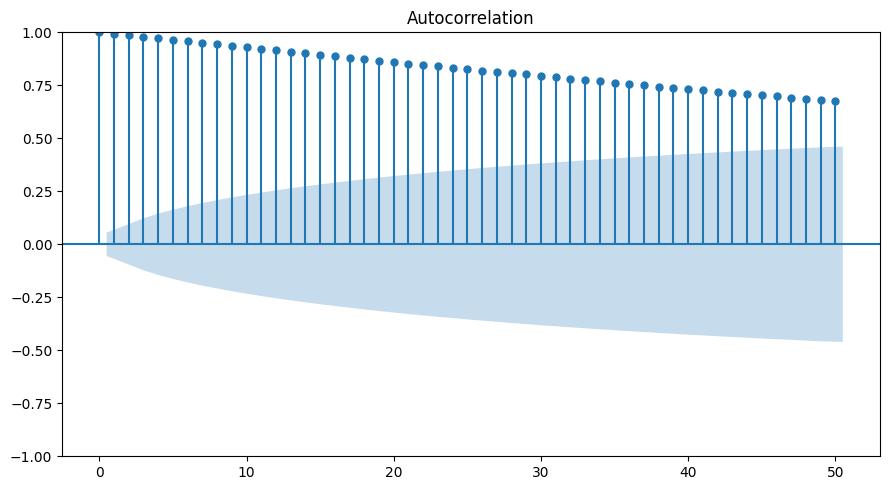

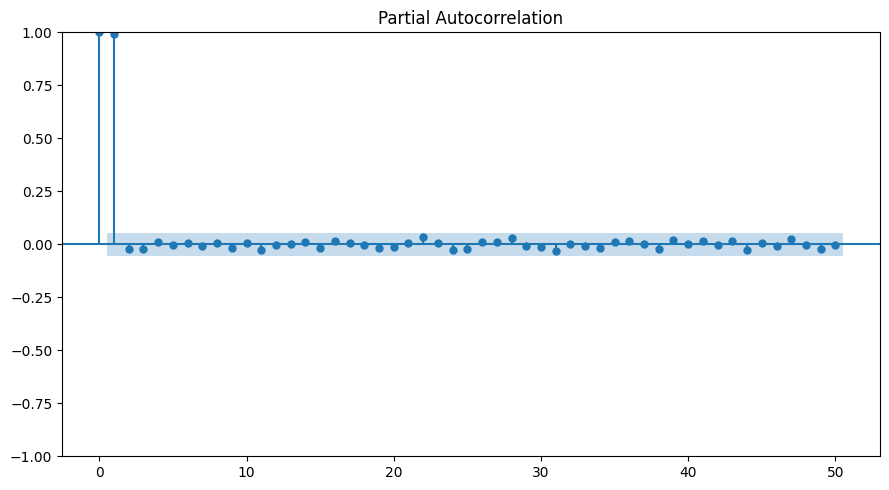

In [85]:
acf_pacf(tesla_ph_dat, 50)

#### Bank of America ACF and PACF

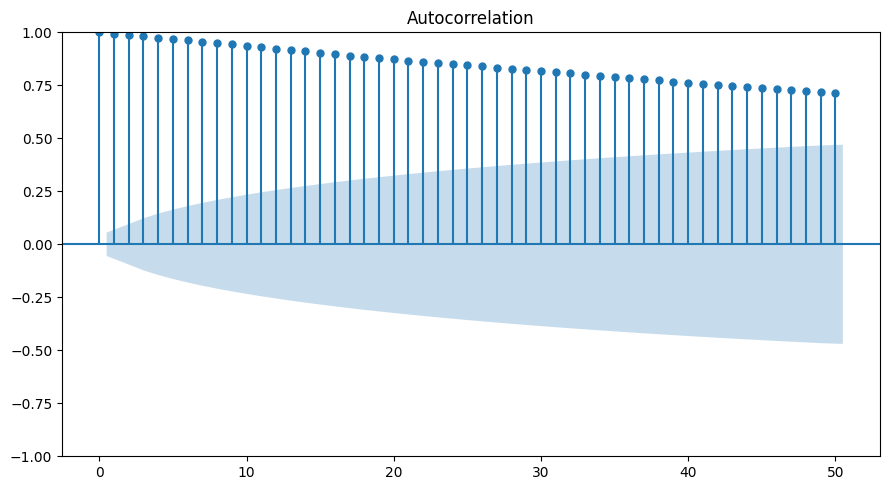

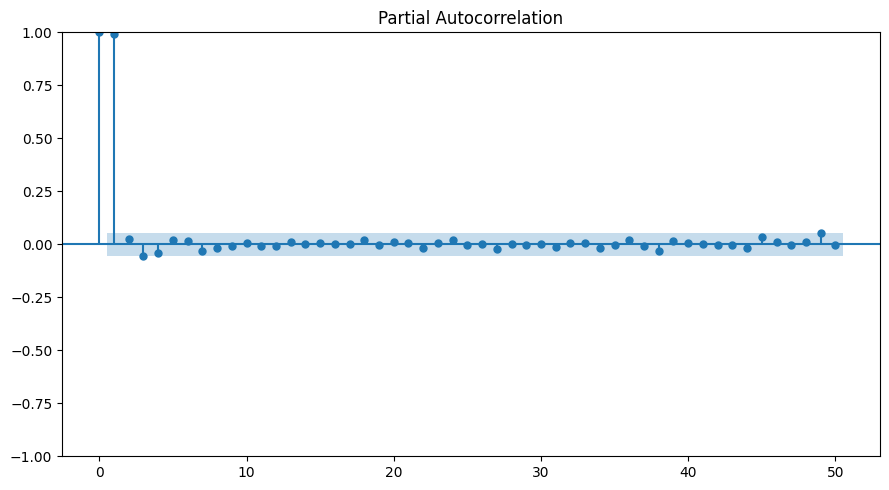

In [86]:
acf_pacf(bac_ph_dat, 50)

#### Apple ACF and PACF

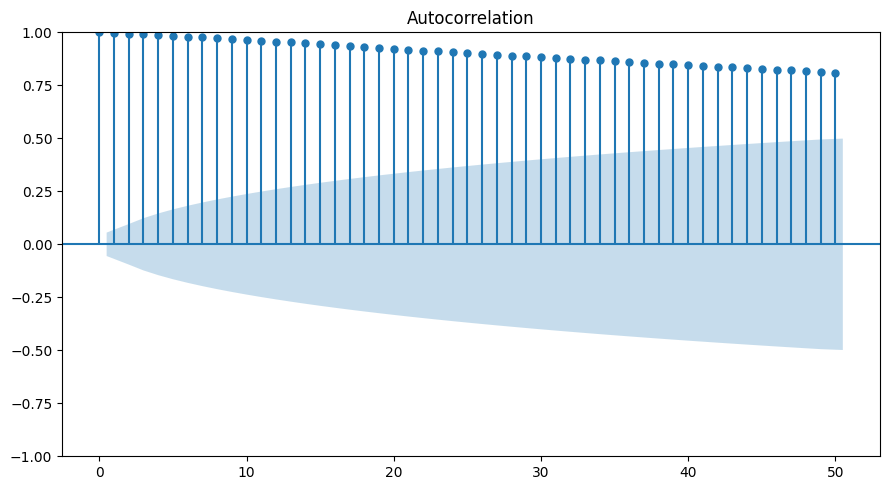

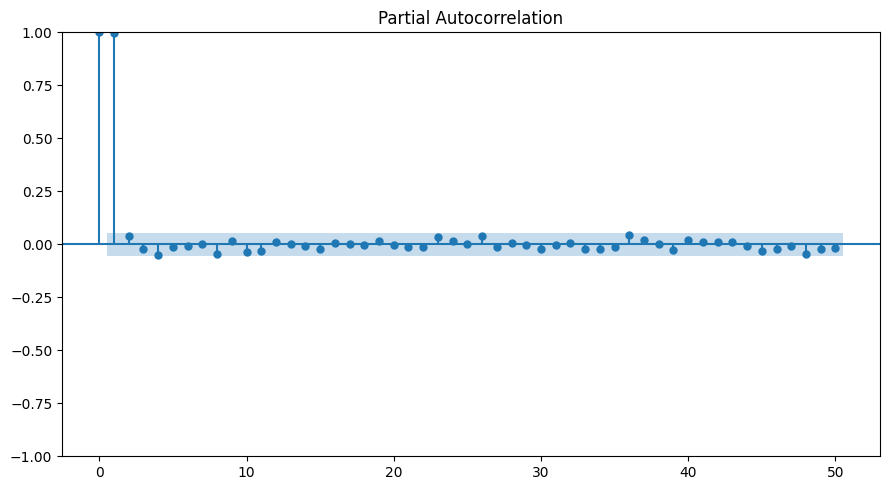

In [87]:
acf_pacf(apple_ph_dat, 50)

#### Facebook ACF and PACF

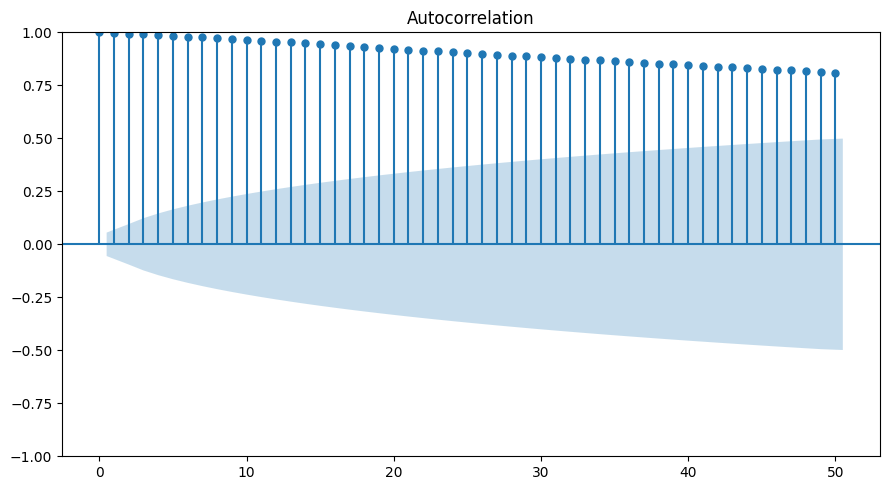

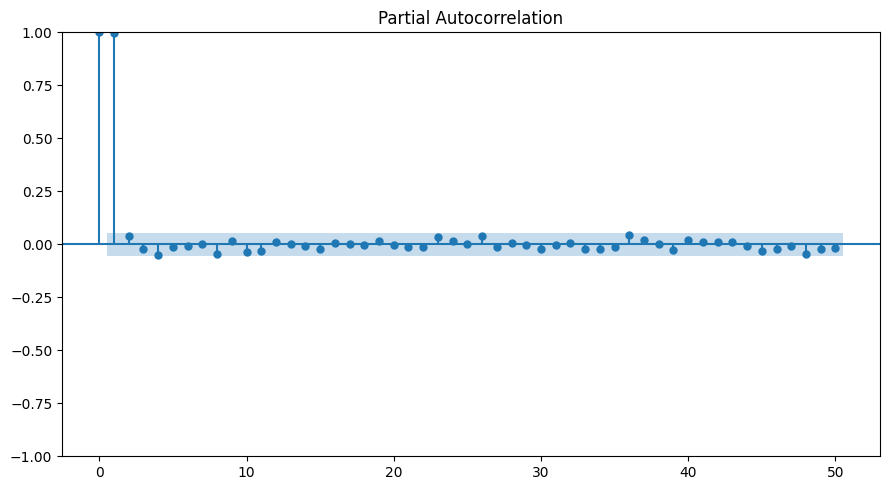

In [88]:
acf_pacf(apple_ph_dat, 50)

#### General Electric ACF and PACF

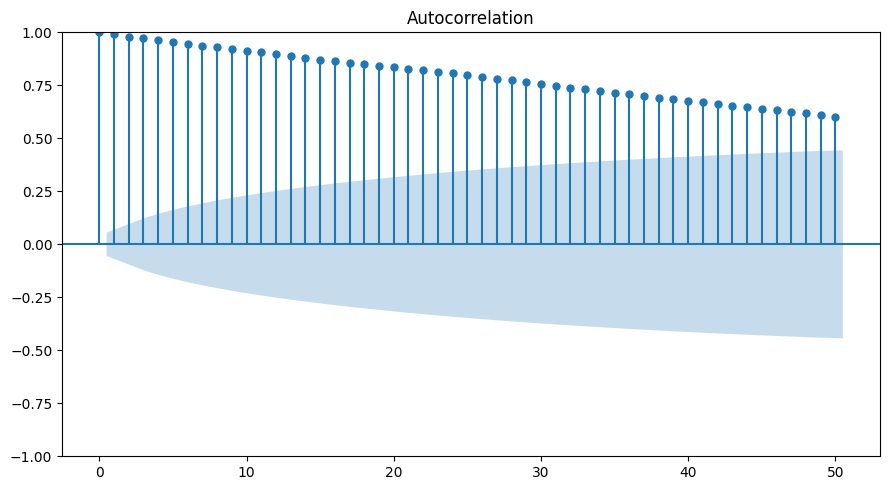

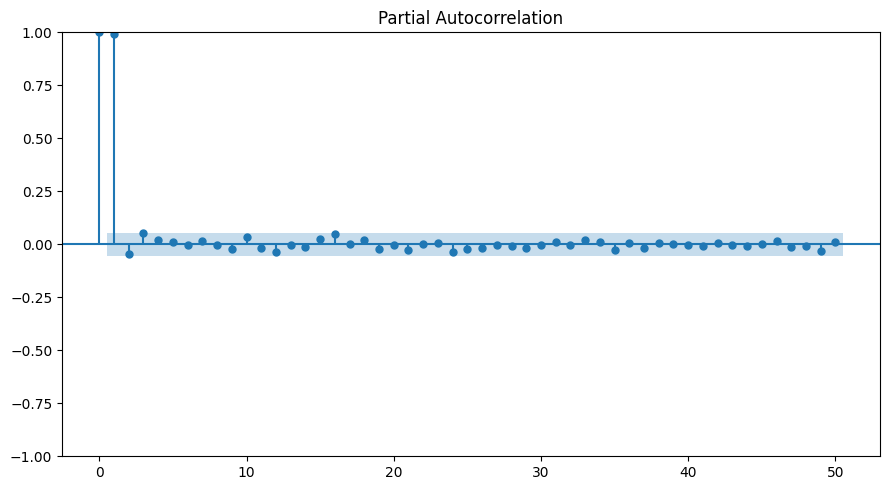

In [89]:
acf_pacf(ge_ph_dat, 50)

##### Interpretation and Inference

**Auto-correlation interpretation** - Slow decline in auto-correlation indicates time-series not stationary, we can prove the stationarity of time-series by Dickey-Fuller test

**Partical auto-correlation interpretation** - For all stocks PACF suggest that time-series dependence can be captured only 1 lag owing to its significance than other laged time-series

### Dickey-Fuller test

The **Dickey-Fuller test** is a statistical test that determines if a unit root is present in an AR (autoregressive) time series model.  It checks for **stationarity** in a time series model, where a unit root indicates that a time series has a stochastic trend.

Stationarity in time series analysis is when the statistical properties of the series remain constant (no change was made when we lag the feature indicating mean, variance, and autocorrelation structure is not dependent on time).  

We can conduct a hypothesis test with the Dickey-Fuller lemma to assess whether our time series data is stationary.

<div style="text-align: center;">
    $H_0$: Beta = 1 (the time-series is non-stationary) <br>
    $H_A$: **Beta < 1 (the time-series is stationary)** 
</div>

Where we have $\alpha$ = 0.05 and we reject if p-value is less than 0.05

In [90]:
from statsmodels.tsa.stattools import adfuller

# funtion to return adfuller test results
def adfuller_test(df):
    adfuller_result = adfuller(df['y'], autolag='AIC')
    adfuller_output = pd.Series(adfuller_result[:4], index=['Test statistic', 'p-value',
                                                           'Lags Used','Number of Observations Used'])
    print(adfuller_output)

#### P-value Computation

In [91]:
print("adfuller test results for TSLA")
adfuller_test(tesla_ph_dat)
print("----"*10)
print("adfuller test results for BAC")
adfuller_test(bac_ph_dat)
print("----"*10)
print("adfuller test results for APPL")
adfuller_test(apple_ph_dat)
print("----"*10)
print("adfuller test results for FB")
adfuller_test(fb_ph_dat)
print("----"*10)
print("adfuller test results for GE")
adfuller_test(ge_ph_dat)

adfuller test results for TSLA
Test statistic                   -2.128574
p-value                           0.233181
Lags Used                         0.000000
Number of Observations Used    1256.000000
dtype: float64
----------------------------------------
adfuller test results for BAC
Test statistic                    0.709335
p-value                           0.990022
Lags Used                         2.000000
Number of Observations Used    1254.000000
dtype: float64
----------------------------------------
adfuller test results for APPL
Test statistic                   -0.552915
p-value                           0.881270
Lags Used                         0.000000
Number of Observations Used    1256.000000
dtype: float64
----------------------------------------
adfuller test results for FB
Test statistic                   -1.620017
p-value                           0.472720
Lags Used                         1.000000
Number of Observations Used    1255.000000
dtype: float64
--------

- For all the stocks, the p-values are all greater than 0.05, thus, we do not have sufficient evidence to reject the null hypothesis.  With a $\alpha$ = 0.05, we do **not have enough evidence** to reject the null hypothesis and conclude that the time-series are not stationary.

#### Finding Degree of Difference

Since we are estimating population variance, we need to find the degrees of freedon that these tests use.  We can use the `pmdarima` library to compute these values.

In [92]:
from pmdarima.arima.utils import ndiffs

# find degree of differencing 
def degree_of_differencing(df, co_name):
    company_ndiffs = ndiffs(df['y'], test = 'adf')
    print(f'The degree of differencing is {company_ndiffs} for {co_name}')
    
    return company_ndiffs

In [93]:
tesla_ddf = degree_of_differencing(tesla_ph_dat, 'Tesla')
bac_ddf = degree_of_differencing(bac_ph_dat, 'Bank of America')
apple_ddf = degree_of_differencing(apple_ph_dat, 'Apple')
fb_ddf = degree_of_differencing(fb_ph_dat, 'Facebook')
ge_ddf = degree_of_differencing(tesla_ph_dat, 'General Electric')

The degree of differencing is 1 for Tesla
The degree of differencing is 1 for Bank of America
The degree of differencing is 1 for Apple
The degree of differencing is 0 for Facebook
The degree of differencing is 1 for General Electric


## Train Forecasting Models Using Auto-ARIMA

- We will be using **Auto-ARIMA** for prediction.  Using Auto-ARIMA will help us predict future securities or financial market moves by examining the differences between values in the series instead of through the actual values.  An ARIMA model uses these features:

- **Auto Regression (AR)**: Refers to a model that shows a changing variable that regresses on its own lagged or prior values

- **Integrated (I)**: Represents the differencing of raw observations to allow for the time series to become stationary (i.e. data values are replaced by the difference between the data values and the previous values)

- **Moving Average (MA)**: Incorporates the dependency between an observation and a residual error from a moving average model applied to lagged observations

We will be writing a funtion to split the train/test split for time-series, similiar to that of splitting the dates (like done above)

In [94]:
# funcrtion to split train and test time-series for modelling purpose
def arima_split(df, co_name):
    size = int(len(df)*0.95)
    train_df = (df['y'])[:size]
    test_df = (df['y'])[size:]
    
    print(f"data splits of company {co_name}")
    print(f"Train Size: {len(train_df)}, Test Size: {len(test_df)}")
    print("-------------------------------")
    
    return train_df, test_df

#### Creating Train/Test Splits

In [95]:
tesla_train, tesla_test = arima_split(tesla_ph_dat, 'TSLA')
bac_train, bac_test = arima_split(bac_ph_dat, 'BAC')
apple_train, apple_test = arima_split(apple_ph_dat, 'APPL')
fb_train, fb_test = arima_split(fb_ph_dat, 'FB')
ge_train, ge_test = arima_split(ge_ph_dat, 'GE')

data splits of company TSLA
Train Size: 1194, Test Size: 63
-------------------------------
data splits of company BAC
Train Size: 1194, Test Size: 63
-------------------------------
data splits of company APPL
Train Size: 1194, Test Size: 63
-------------------------------
data splits of company FB
Train Size: 1194, Test Size: 63
-------------------------------
data splits of company GE
Train Size: 1194, Test Size: 63
-------------------------------


#### Hyper-Parameter Optimization

In [96]:
def find_best_fit_arima(df, co_name):
    print(f"Arima model for {co_name}")

    model = pm.auto_arima(df, test = 'adf', 
                          start_p = 1, start_q = 1,     
                          max_p = 3, max_q = 3,
                          d = None, seasonal = True,   
                          start_P = 0, m = 3,
                          trace = True, error_action = 'ignore',  
                          suppress_warnings = True, stepwise = True,
                          D = 1, information_criterion = 'aic')

    print(model.summary())
    print('\n')
    
    return model